# DNS Loan Prediction

In [1]:
%load_ext watermark
%watermark -d -m -v -p numpy,matplotlib,sklearn,eli5,seaborn,yellowbrick,statsmodels,patsy,xgboost,pandas -g

2019-02-01 

CPython 3.6.5
IPython 6.4.0

numpy 1.14.3
matplotlib 2.2.2
sklearn 0.19.1
eli5 0.8
seaborn 0.9.0
yellowbrick 0.8
statsmodels 0.9.0
patsy 0.5.0
xgboost 0.81
pandas 0.23.0

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 61 Stepping 4, GenuineIntel
CPU cores  : 4
interpreter: 64bit
Git hash   :


## DESCRIPTION OF THE CHALLENGE:

SuperLender is a local digital lending company, which prides itself in its effective use of credit risk models to deliver profitable and high-impact loan alternative. Its assessment approach is based on two main risk drivers of loan default prediction:.
- 1) willingness to pay and 
- 2) ability to pay. Since not all customers pay back, the company invests in experienced data scientist to build robust models to effectively predict the odds of repayment.

These two fundamental drivers need to be determined at the point of each application to allow the credit grantor to make a calculated decision based on repayment odds, which in turn determines if an applicant should get a loan, and if so - what the size, price and tenure of the offer will be.

There are two types of risk models in general: New business risk, which would be used to assess the risk of application(s) associated with the first loan that he/she applies. The second is a repeat or behaviour risk model, in which case the customer has been a client and applies for a repeat loan. In the latter case - we will have additional performance on how he/she repaid their prior loans, which we can incorporate into our risk model.

It is your job to predict if a loan was good or bad, i.e. accurately predict binary outcome variable, where Good is 1 and Bad is 0.

### Problem

This competition is a supervised classification machine learning task. The objective is to use historical financial and socioeconomic data to predict whether or not an applicant will be able to repay a loan. This is a standard supervised classification task:

* __Supervised__: The labels are included in the training data and the goal is to train a model to learn to predict the labels from the features
* __Classification__: The label is a binary variable, 0 (will repay loan on time), 1 (will have difficulty repaying loan)

### Description of the data

There are 3 different datasets for both train and test

#### Demographic data (traindemographics.csv)
- customerid (Primary key used to merge to other data)
- birthdate (date of birth of the customer)
- bank_account_type (type of primary bank account)
- longitude_gps
- latitude_gps
- bank_name_clients (name of the bank)
- bank_branch_clients (location of the branch - not compulsory - so missing in a lot of the cases)
- employment_status_clients (type of employment that customer has)
- level_of_education_clients (highest level of education)

#### Performance data (trainperf.csv) : 
This is the repeat loan that the customer has taken for which we need to predict the performance of. Basically, we need to predict if whether this loan would default given all previous loans and demographics of a customer.
- customerid (Primary key used to merge to other data)
- systemloanid (The id associated with the particular loan. The same customerId can have multiple systemloanid’s for each loan he/she has taken out)
- loannumber (The number of the loan that you have to predict)
- approveddate (Date that loan was approved)
- creationdate (Date that loan application was created)
- loanamount (Loan value taken)
- totaldue (Total repayment required to settle the loan - this is the capital loan value disbursed +interest and fees)
- termdays (Term of loan)
- referredby (customerId of the customer that referred this person - is missing, then not referred)
- good_bad_flag (good = settled loan on time; bad = did not settled loan on time) - this is the target variable that we need to predic

#### Previous loans data (trainprevloans.csv) : 
This dataset contains all previous loans that the customer had prior to the loan above that we want to predict the performance of. Each loan will have a different systemloanid, but the same customerid for each customer.

- customerid (Primary key used to merge to other data)
- systemloanid (The id associated with the particular loan. The same customerId can have multiple systemloanid’s for each loan he/she has taken out)
- loannumber (The number of the loan that you have to predict)
- approveddate (Date that loan was approved)
- creationdate (Date that loan application was created)
- loanamount (Date that loan application was created)
- totaldue (Total repayment required to settle the loan - this is the capital loan value disbursed +interest and fees) termdays (Term of loan)
- closeddate (Date that the loan was settled)
- referredby (customerId of the customer that referred this person - is missing, then not refrerred)
- firstduedate (Date of first payment due in cases where the term is longer than 30 days. So in the case where the term is 60+ days - then there are multiple monthly payments due - and this dates reflects the date of the first payment)
- firstrepaiddate (Actual date that he/she paid the first payment as defined above)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools
from scipy import stats

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore') 

# File system manangement
import os

from PIL import  Image
import itertools
#from wordcloud import WordCloud,STOPWORDS
import io
import base64
from matplotlib import rc,animation
#from mpl_toolkits.mplot3d import Axes3D
#from mpl_toolkits.basemap import Basemap
#import folium
#import folium.plugins
import datetime as dt
from IPython.display import display # Allows the use of display() for DataFrames

# memory management
import gc

In [3]:
#Setting styles and aesthetics
pd.options.display.max_columns =200
pd.options.display.max_rows =10
pd.options.display.float_format = '{:,.2f}'.format

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (18, 8)

# Graphics in SVG format are more sharp and legible
%config InlineBackend.figure_format = 'svg'

%matplotlib inline

---

## Load The Data

In [4]:
# Function To Optimize Data Load
# Thanks You Guillaume Martin for the Awesome Memory Optimizer!
# https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtypes

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else: df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(
        100 * (start_mem - end_mem) / start_mem))

    return df

In [5]:
def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [6]:
# Load Files - Thanks Cafeal, very nifty
# https://www.kaggle.com/cafeal/lightgbm-trial-public-0-742
input_files = os.listdir("../data/raw/")
for filename in input_files:
    locals()[filename.rstrip('.csv')] = import_data(f'../data/raw/{filename}')  # .sample(1000)
    print(filename.rstrip('.csv'), "## Loaded and Optimized ##\n")

Memory usage of dataframe is 0.10 MB
Memory usage after optimization is: 0.09 MB
Decreased by 16.7%
testdemographi ## Loaded and Optimized ##

Memory usage of dataframe is 0.10 MB
Memory usage after optimization is: 0.06 MB
Decreased by 36.1%
testperf ## Loaded and Optimized ##

Memory usage of dataframe is 0.54 MB
Memory usage after optimization is: 0.37 MB
Decreased by 31.2%
testprevloan ## Loaded and Optimized ##

Memory usage of dataframe is 0.30 MB
Memory usage after optimization is: 0.25 MB
Decreased by 16.7%
traindemographi ## Loaded and Optimized ##

Memory usage of dataframe is 0.33 MB
Memory usage after optimization is: 0.22 MB
Decreased by 35.0%
trainperf ## Loaded and Optimized ##

Memory usage of dataframe is 1.66 MB
Memory usage after optimization is: 1.18 MB
Decreased by 29.2%
trainprevloan ## Loaded and Optimized ##



### Data Dimension

In [7]:
# Check The Shape Of The Data Loaded
print('Test Demographic shape: {} Rows, {} Columns'.format(*testdemographi.shape))
print('Test Performance shape: {} Rows, {} Columns'.format(*testperf.shape))
print('Test Previous Loan shape: {} Rows, {} Columns'.format(*testprevloan.shape))
print('Train Demographic shape: {} Rows, {} Columns'.format(*traindemographi.shape))
print('Train Performance shape: {} Rows, {} Columns'.format(*trainperf.shape))
print('Train Previous Loan shape: {} Rows, {} Columns'.format(*trainprevloan.shape))

Test Demographic shape: 1487 Rows, 9 Columns
Test Performance shape: 1450 Rows, 9 Columns
Test Previous Loan shape: 5907 Rows, 12 Columns
Train Demographic shape: 4346 Rows, 9 Columns
Train Performance shape: 4368 Rows, 10 Columns
Train Previous Loan shape: 18183 Rows, 12 Columns


### First Few rows of Data

In [8]:
# Print First Few Rows Of The Data
display("test demographics")
display(testdemographi.head(3))
display("test performance")
display(testperf.head(3))
display("test previous loans")
display(testprevloan.head(3))
display("train demographics")
display(traindemographi.head(3))
display("train performance")
display(trainperf.head(3))
display("train previous loans")
display(trainprevloan.head(3))

'test demographics'

customerid                   birthdate  \
0  8a858f305c8dd672015c93b1db645db4  1976-08-28 00:00:00.000000   
1  8a858f085a477386015a47fb049e49ca  1978-06-23 00:00:00.000000   
2  8a858e6f5cd5e874015cd6f5634c39ad  1984-04-04 00:00:00.000000   

  bank_account_type  longitude_gps  latitude_gps bank_name_clients  \
0           Savings           5.30          7.59     Heritage Bank   
1           Savings           3.29          6.60               UBA   
2           Savings           8.50          7.73        First Bank   

  bank_branch_clients employment_status_clients level_of_education_clients  
0                 NaN                 Permanent                        NaN  
1                 NaN                 Permanent                        NaN  
2                 NaN                 Permanent                        NaN

'test performance'

customerid  systemloanid  loannumber approveddate  \
0  8a858899538ddb8e015390510b321f08     301998974           4      40:48.0   
1  8a858959537a097401537a4e316e25f7     301963615          10      43:40.0   
2  8a8589c253ace09b0153af6ba58f1f31     301982236           6      15:11.0   

  creationdate  loanamount  totaldue  termdays referredby  
0      39:35.0       10000 12,250.00        30        NaN  
1      42:34.0       40000 44,000.00        30        NaN  
2      15:04.0       20000 24,500.00        30        NaN

'test previous loans'

customerid  systemloanid  loannumber  \
0  8a858899538ddb8e015390510b321f08     301621635           3   
1  8a858959537a097401537a4e316e25f7     301810201           5   
2  8a858959537a097401537a4e316e25f7     301831255           6   

                 approveddate                creationdate  loanamount  \
0  2016-05-17 10:37:00.000000  2016-05-17 09:36:55.000000   10,000.00   
1  2017-02-04 21:28:59.000000  2017-02-04 20:28:52.000000   30,000.00   
2  2017-03-04 10:28:22.000000  2017-03-04 09:28:16.000000   30,000.00   

   totaldue  termdays                  closeddate referredby  \
0 13,000.00        30  2016-06-17 00:04:15.000000        NaN   
1 36,800.00        60  2017-03-02 16:22:58.000000        NaN   
2 34,400.00        30  2017-04-02 00:44:24.000000        NaN   

                 firstduedate             firstrepaiddate  
0  2016-06-16 00:00:00.000000  2016-06-16 15:44:08.000000  
1  2017-03-06 00:00:00.000000  2017-03-02 16:07:47.000000  
2  2017-04-03 00:00:00.000000  2017-04-01 21:29:46.000000

'train demographics'

customerid                   birthdate  \
0  8a858e135cb22031015cbafc76964ebd  1973-10-10 00:00:00.000000   
1  8a858e275c7ea5ec015c82482d7c3996  1986-01-21 00:00:00.000000   
2  8a858e5b5bd99460015bdc95cd485634  1987-04-01 00:00:00.000000   

  bank_account_type  longitude_gps  latitude_gps bank_name_clients  \
0           Savings           3.32          6.53           GT Bank   
1           Savings           3.33          7.12     Sterling Bank   
2           Savings           5.75          5.56     Fidelity Bank   

  bank_branch_clients employment_status_clients level_of_education_clients  
0                 NaN                       NaN                        NaN  
1                 NaN                 Permanent                        NaN  
2                 NaN                       NaN                        NaN

'train performance'

customerid  systemloanid  loannumber  \
0  8a2a81a74ce8c05d014cfb32a0da1049     301994762          12   
1  8a85886e54beabf90154c0a29ae757c0     301965204           2   
2  8a8588f35438fe12015444567666018e     301966580           7   

                 approveddate                creationdate  loanamount  \
0  2017-07-25 08:22:56.000000  2017-07-25 07:22:47.000000   30,000.00   
1  2017-07-05 17:04:41.000000  2017-07-05 16:04:18.000000   15,000.00   
2  2017-07-06 14:52:57.000000  2017-07-06 13:52:51.000000   20,000.00   

   totaldue  termdays referredby good_bad_flag  
0 34,500.00        30        NaN          Good  
1 17,250.00        30        NaN          Good  
2 22,250.00        15        NaN          Good

'train previous loans'

customerid  systemloanid  loannumber  \
0  8a2a81a74ce8c05d014cfb32a0da1049     301682320           2   
1  8a2a81a74ce8c05d014cfb32a0da1049     301883808           9   
2  8a2a81a74ce8c05d014cfb32a0da1049     301831714           8   

                 approveddate                creationdate  loanamount  \
0  2016-08-15 18:22:40.000000  2016-08-15 17:22:32.000000   10,000.00   
1  2017-04-28 18:39:07.000000  2017-04-28 17:38:53.000000   10,000.00   
2  2017-03-05 10:56:25.000000  2017-03-05 09:56:19.000000   20,000.00   

   totaldue  termdays                  closeddate referredby  \
0 13,000.00        30  2016-09-01 16:06:48.000000        NaN   
1 13,000.00        30  2017-05-28 14:44:49.000000        NaN   
2 23,800.00        30  2017-04-26 22:18:56.000000        NaN   

                 firstduedate             firstrepaiddate  
0  2016-09-14 00:00:00.000000  2016-09-01 15:51:43.000000  
1  2017-05-30 00:00:00.000000  2017-05-26 00:00:00.000000  
2  2017-04-04 00:00:00.000000  2017-04-26 22:03:47.000000

---

## DATA EXPLORATION

In [9]:
# Merge The Datasets : Only Demographic and Performance
train = pd.merge(trainperf, traindemographi, on="customerid", how="left")
test  = pd.merge(testdemographi, testperf, on="customerid", how="left")

In [10]:
# Check The Shape Of The New Dataset
print('Train shape: {} Rows, {} Columns'.format(*train.shape))
print('Test  shape: {} Rows, {} Columns'.format(*test.shape))

Train shape: 4376 Rows, 18 Columns
Test  shape: 1487 Rows, 17 Columns


In [11]:
# Export The Dataset to create reproducability
train.to_csv('../data/processed/train.csv', index=False)
test.to_csv('../data/processed/test.csv', index=False)
trainprevloan.to_csv('../data/processed/trainprevloan.csv', index=False)
testprevloan.to_csv('../data/processed/testprevloan.csv', index=False)

Use pandas profiling to get summary details of each dataset

In [12]:
import pandas_profiling

In [15]:
#profile = pandas_profiling.ProfileReport(train)
#profile.to_file(outputfile="../reports/html/train.html")

In [16]:
#profile = pandas_profiling.ProfileReport(test)
#profile.to_file(outputfile="../reports/html/test.html")

In [17]:
#profile = pandas_profiling.ProfileReport(trainprevloan)
#profile.to_file(outputfile="../reports/html/trainprevloan.html")

In [18]:
#profile = pandas_profiling.ProfileReport(testprevloan)
#profile.to_file(outputfile="../reports/html/testprevloan.html")

---

## DATA PREPARATION

### Convert the date columns

In [13]:
# Convert the date columns in test dataset
test['birthdate']    = pd.to_datetime(test['birthdate'], format='%Y-%m-%d %H:%M:%S')
test['approveddate'] = pd.to_datetime(test['approveddate'], format='%M:%S.%f')
test['creationdate'] = pd.to_datetime(test['creationdate'], format='%M:%S.%f')

In [14]:
# Convert the date columns in train dataset
train['birthdate']    = pd.to_datetime(train['birthdate'], format='%Y-%m-%d %H:%M:%S')
train['approveddate'] = pd.to_datetime(train['approveddate'], format='%Y-%m-%d %H:%M:%S')
train['creationdate'] = pd.to_datetime(train['creationdate'], format='%Y-%m-%d %H:%M:%S')

In [15]:
# Convert the date columns in test previous loan dataset
testprevloan['closeddate']      = pd.to_datetime(testprevloan['closeddate'], format='%Y-%m-%d %H:%M:%S')
testprevloan['approveddate']    = pd.to_datetime(testprevloan['approveddate'], format='%Y-%m-%d %H:%M:%S')
testprevloan['creationdate']    = pd.to_datetime(testprevloan['creationdate'], format='%Y-%m-%d %H:%M:%S')
testprevloan['firstduedate']    = pd.to_datetime(testprevloan['firstduedate'], format='%Y-%m-%d %H:%M:%S')
testprevloan['firstrepaiddate'] = pd.to_datetime(testprevloan['firstrepaiddate'], format='%Y-%m-%d %H:%M:%S')

In [16]:
# Convert the date columns in train previous loan dataset
trainprevloan['closeddate']      = pd.to_datetime(trainprevloan['closeddate'], format='%Y-%m-%d %H:%M:%S')
trainprevloan['approveddate']    = pd.to_datetime(trainprevloan['approveddate'], format='%Y-%m-%d %H:%M:%S')
trainprevloan['creationdate']    = pd.to_datetime(trainprevloan['creationdate'], format='%Y-%m-%d %H:%M:%S')
trainprevloan['firstduedate']    = pd.to_datetime(trainprevloan['firstduedate'], format='%Y-%m-%d %H:%M:%S')
trainprevloan['firstrepaiddate'] = pd.to_datetime(trainprevloan['firstrepaiddate'], format='%Y-%m-%d %H:%M:%S')

### Create the TARGET Variable 

In [17]:
# Convert the good_bad_flag into numerical binary variable 
train['TARGET'] = np.where(train['good_bad_flag'] == 'Good', 0, 1)

### Merge the datasets 

In [18]:
#create one dataframe and Add identifying column
train['set'] = 'train'
test['set'] = 'test'
test["TARGET"] = np.nan

In [19]:
#Append the dataframes
#app = train.append(test, ignore_index = True)
app = pd.concat([train,test], ignore_index = True)
app.shape

(5863, 20)

In [20]:
display(app.tail(3))

TARGET approveddate bank_account_type bank_branch_clients  \
5860     nan          NaT           Savings                 NaN   
5861     nan          NaT           Savings                 NaN   
5862     nan          NaT           Savings                 NaN   

     bank_name_clients  birthdate creationdate  \
5860        First Bank 1988-06-12          NaT   
5861              FCMB 1974-03-23          NaT   
5862      Stanbic IBTC 1987-02-16          NaT   

                            customerid employment_status_clients  \
5860  8a858e8b5bc9e7e6015bcd7374077f0c                 Permanent   
5861  8a858f2e5c699f3a015c77aa22ed7f23                 Permanent   
5862  8a858fde580afd48015818eda53830c8                 Permanent   

     good_bad_flag  latitude_gps level_of_education_clients  loanamount  \
5860           NaN          6.46                        NaN         nan   
5861           NaN          7.11                        NaN         nan   
5862           NaN          6.56                   Graduate         nan   

      loannumber  longitude_gps referredby   set  systemloanid  termdays  \
5860         nan           3.43        NaN  test           nan       nan   
5861         nan           3.32        NaN  test           nan       nan   
5862         nan           3.37        NaN  test           nan       nan   

      totaldue  
5860       nan  
5861       nan  
5862       nan

In [21]:
# Create one dataframe for previous loans and add identifyng column
trainprevloan['set'] = 'train'
testprevloan['set'] = 'test'
#Append the dataframes
#app_prev = trainprevloan.append(testprevloan, ignore_index = True)
app_prev = pd.concat([trainprevloan,testprevloan], ignore_index = True)
app_prev.shape

(24090, 13)

In [22]:
display(app_prev.tail(3))

customerid  systemloanid  loannumber  \
24087  8a858fab5b9105dc015b975e594e394a     301952446           1   
24088  8a858fcf5b39c3ba015b39c7691603e1     301887884           2   
24089  8a858e165cf9d8e3015cfffb0c61459f     301959483           1   

             approveddate        creationdate  loanamount  totaldue  termdays  \
24087 2017-06-26 15:46:28 2017-06-26 14:45:20   10,000.00 13,000.00        30   
24088 2017-05-03 06:56:10 2017-05-03 05:56:04   10,000.00 13,000.00        30   
24089 2017-07-01 22:23:15 2017-07-01 21:22:08   10,000.00 13,000.00        30   

               closeddate referredby firstduedate     firstrepaiddate   set  
24087 2017-07-13 13:12:43        NaN   2017-07-26 2017-07-13 13:02:34  test  
24088 2017-06-01 22:00:17        NaN   2017-06-02 2017-06-01 21:50:07  test  
24089 2017-07-29 14:25:20        NaN   2017-07-31 2017-07-29 14:15:11  test

### Remove Duplicate Columns

In [23]:
%%time
def duplicate_columns(frame):
    groups = frame.columns.to_series().groupby(frame.dtypes).groups
    dups = []

    for t, v in groups.items():

        cs = frame[v].columns
        vs = frame[v]
        lcs = len(cs)

        for i in range(lcs):
            ia = vs.iloc[:,i].values
            for j in range(i+1, lcs):
                ja = vs.iloc[:,j].values
                if np.array_equal(ia, ja):
                    dups.append(cs[i])
                    break

    return dups

colsToRemove = duplicate_columns(app)
colsToRemove1 = duplicate_columns(app_prev)
print(colsToRemove)
print(colsToRemove1)

[]
[]
Wall time: 157 ms


In [24]:
# remove duplicate columns in the training set
app.drop(colsToRemove, axis=1, inplace=True) 

# remove duplicate columns in the testing set
app_prev.drop(colsToRemove1, axis=1, inplace=True)

print("Removed `{}` Duplicate Columns\n".format(len(colsToRemove)))
print(colsToRemove)
print("Removed `{}` Duplicate Columns\n".format(len(colsToRemove1)))
print(colsToRemove1)

Removed `0` Duplicate Columns

[]
Removed `0` Duplicate Columns

[]


### Drop Sparse Data

In [25]:
#Sparse data means that many of the values are zero, but you know that they are zero.
#Missing data means that you don't know what some or many of the values are

In [26]:
#make sure columns are numerical
def drop_sparse(data):
    flist = [x for x in data.columns if not x in ['Customer','TARGET']]
    for f in flist:
        if len(np.unique(data[f]))<2:
            data.drop(f, axis=1, inplace=True)
    return data

In [27]:
%%time
#data = drop_sparse(data)

Wall time: 0 ns


In [28]:
gc.collect()

63

### Missing Values

#### Percentage of Missing values in application train and test data

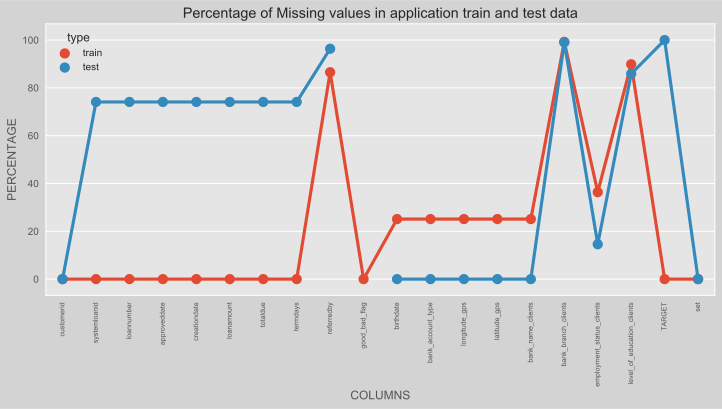

In [29]:
fig = plt.figure(figsize=(12,5))
miss_train = pd.DataFrame((train.isnull().sum())*100/train.shape[0]).reset_index()
miss_test = pd.DataFrame((test.isnull().sum())*100/test.shape[0]).reset_index()
miss_train["type"] = "train"
miss_test["type"]  =  "test"
missing = pd.concat([miss_train,miss_test],axis=0)
ax = sns.pointplot("index",0,data=missing,hue="type")
plt.xticks(rotation =90,fontsize =7)
plt.title("Percentage of Missing values in application train and test data")
plt.ylabel("PERCENTAGE")
plt.xlabel("COLUMNS")
#ax.set_facecolor("k")
fig.set_facecolor("lightgrey")

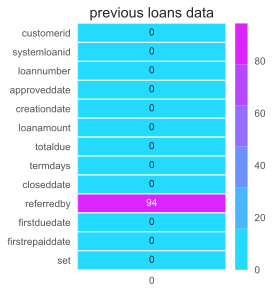

In [30]:
# Check missing value in the other dataset
plt.figure(figsize=(10,10))
plt.subplot(221)
sns.heatmap(pd.DataFrame(app_prev.isnull().sum()/app_prev.shape[0]*100),annot=True,
            cmap=sns.color_palette("cool"),linewidth=1,linecolor="white")
plt.title("previous loans data")
plt.subplots_adjust(wspace = 1)

#### Drop features with high % of missing values

In [31]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [32]:
# Missing values statistics
missing_values_table(app)

Your selected dataframe has 20 columns.
There are 18 columns that have missing values.


Missing Values  % of Total Values
bank_branch_clients                   5816              99.20
referredby                            5220              89.00
level_of_education_clients            5210              88.90
employment_status_clients             1809              30.90
TARGET                                1487              25.40
...                                    ...                ...
longitude_gps                         1099              18.70
birthdate                             1099              18.70
bank_name_clients                     1099              18.70
bank_account_type                     1099              18.70
latitude_gps                          1099              18.70

[18 rows x 2 columns]

In [33]:
# Missing values statistics
missing_values_table(app_prev)

Your selected dataframe has 13 columns.
There are 1 columns that have missing values.


Missing Values  % of Total Values
referredby           22739              94.40

In [34]:
# Get the columns with > 80% missing
missing_df = missing_values_table(app);
missing_columns = list(missing_df[missing_df['% of Total Values'] > 80].index)
print('We will remove %d columns.' % len(missing_columns))

Your selected dataframe has 20 columns.
There are 18 columns that have missing values.
We will remove 3 columns.


In [35]:
# Get the columns with > 80% missing
missing_df2 = missing_values_table(app_prev);
missing_columns2 = list(missing_df2[missing_df2['% of Total Values'] > 80].index)
print('We will remove %d columns.' % len(missing_columns2))

Your selected dataframe has 13 columns.
There are 1 columns that have missing values.
We will remove 1 columns.


In [36]:
# Drop the columns
app = app.drop(columns = list(missing_columns))
app_prev = app_prev.drop(columns = list(missing_columns2))

In [37]:
print("The loan data has", app.shape,"dimension")
print("The previous loan data has", app_prev.shape,"dimension")

The loan data has (5863, 17) dimension
The previous loan data has (24090, 12) dimension


In [38]:
display(app.head(3))
display(app_prev.head(3))

TARGET        approveddate bank_account_type bank_name_clients  birthdate  \
0    0.00 2017-07-25 08:22:56             Other      Diamond Bank 1972-01-15   
1    0.00 2017-07-05 17:04:41           Savings           GT Bank 1985-08-23   
2    0.00 2017-07-06 14:52:57             Other           EcoBank 1984-09-18   

         creationdate                        customerid  \
0 2017-07-25 07:22:47  8a2a81a74ce8c05d014cfb32a0da1049   
1 2017-07-05 16:04:18  8a85886e54beabf90154c0a29ae757c0   
2 2017-07-06 13:52:51  8a8588f35438fe12015444567666018e   

  employment_status_clients good_bad_flag  latitude_gps  loanamount  \
0                 Permanent          Good          6.43   30,000.00   
1                 Permanent          Good          7.32   15,000.00   
2                 Permanent          Good         10.29   20,000.00   

   loannumber  longitude_gps    set   systemloanid  termdays  totaldue  
0       12.00           3.43  train 301,994,762.00     30.00 34,500.00  
1        2.00           3.88  train 301,965,204.00     30.00 17,250.00  
2        7.00          11.14  train 301,966,580.00     15.00 22,250.00

customerid  systemloanid  loannumber  \
0  8a2a81a74ce8c05d014cfb32a0da1049     301682320           2   
1  8a2a81a74ce8c05d014cfb32a0da1049     301883808           9   
2  8a2a81a74ce8c05d014cfb32a0da1049     301831714           8   

         approveddate        creationdate  loanamount  totaldue  termdays  \
0 2016-08-15 18:22:40 2016-08-15 17:22:32   10,000.00 13,000.00        30   
1 2017-04-28 18:39:07 2017-04-28 17:38:53   10,000.00 13,000.00        30   
2 2017-03-05 10:56:25 2017-03-05 09:56:19   20,000.00 23,800.00        30   

           closeddate firstduedate     firstrepaiddate    set  
0 2016-09-01 16:06:48   2016-09-14 2016-09-01 15:51:43  train  
1 2017-05-28 14:44:49   2017-05-30 2017-05-26 00:00:00  train  
2 2017-04-26 22:18:56   2017-04-04 2017-04-26 22:03:47  train

---

## DATA ANALYSIS

### Response Variable
>Target variable (1 - client is defaulter, 0 - all other cases)                                                                                                                                                                                                                                                                                                
>**22%** out  of total client  population  are depressed.  

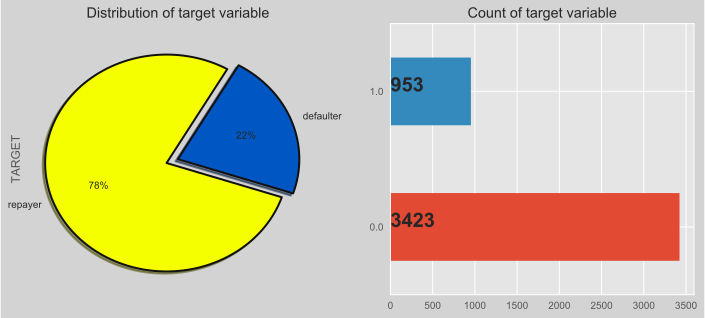

In [39]:
# Distribution of the target variable
fig = plt.figure(figsize=(12, 5))
plt.subplot(121)
app[app["set"] == "train"]["TARGET"].value_counts().plot.pie(autopct = "%1.0f%%",colors = sns.color_palette("prism",7),startangle = 60,labels=["repayer","defaulter"],
                                                                        wedgeprops={"linewidth":2,"edgecolor":"k"},explode=[.1,0],shadow =True)
plt.title("Distribution of target variable")

plt.subplot(122)
ax = app[app["set"] == "train"]["TARGET"].value_counts().plot(kind="barh")

for i,j in enumerate(app[app["set"] == "train"]["TARGET"].value_counts().values):
    ax.text(.7,i,j,weight = "bold",fontsize=20)

plt.title("Count of target variable")
#ax.set_facecolor("k")
fig.set_facecolor("lightgrey")
plt.show()

**<font color="red">This is an imbalanced problem. We will look into it later**

#### 1 . EDA - totaldue,termdays

In [40]:
print('Highest total due amount is:',app['totaldue'].max())
print('Lowest total due amount is:',app['totaldue'].min())
print('Average total due amount is:',app['totaldue'].mean())
print('Median total due amount is:', app['totaldue'].median())

Highest total due amount is: 68100.0
Lowest total due amount is: 10000.0
Average total due amount is: 21226.9296875
Median total due amount is: 13000.0


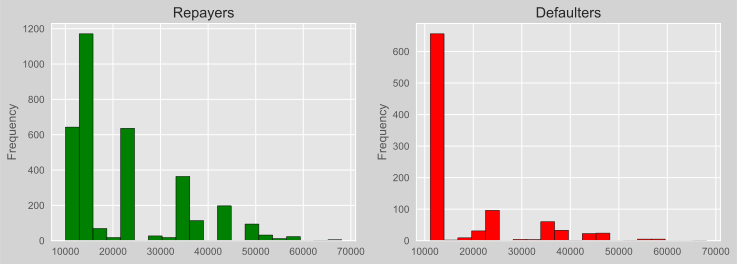

In [41]:
fig,ax=plt.subplots(1,2,figsize=(12,4))
train[train['TARGET']==0].totaldue.plot.hist(ax=ax[0],bins=20,edgecolor='black',color='green')
ax[0].set_title('Repayers')
train[train['TARGET']==1].totaldue.plot.hist(ax=ax[1],color='red',bins=20,edgecolor='black')
ax[1].set_title('Defaulters')
fig.set_facecolor("lightgrey")
plt.show()

In [42]:
# Check and replace missing value
app['totaldue'].isnull().sum()

1102

In [43]:
app['totaldue'].fillna(app['totaldue'].median(), inplace=True)

---------

In [44]:
print('Highest total days is:', app['termdays'].max())
print('Lowest total days is:', app['termdays'].min())
print('Average total days is:', app['termdays'].mean())
print('Median total days is:', app['termdays'].median())

Highest total days is: 90.0
Lowest total days is: 15.0
Average total days is: 29.224952741020793
Median total days is: 30.0


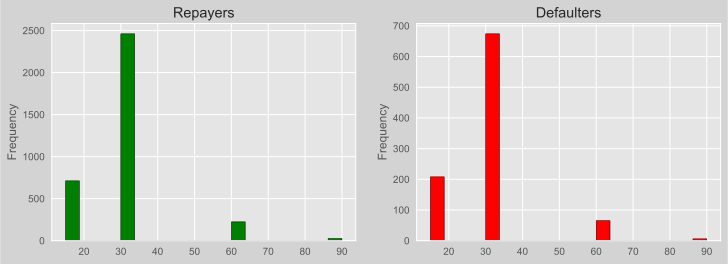

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
train[train['TARGET'] == 0].termdays.plot.hist(
    ax=ax[0], bins=20, edgecolor='black', color='green')
ax[0].set_title('Repayers')
train[train['TARGET'] == 1].termdays.plot.hist(
    ax=ax[1], color='red', bins=20, edgecolor='black')
ax[1].set_title('Defaulters')
fig.set_facecolor("lightgrey")
plt.show()

In [46]:
# Check and replace missing value
app['termdays'].isnull().sum()

1102

In [47]:
app['termdays'].fillna(app['termdays'].mean(), inplace=True)

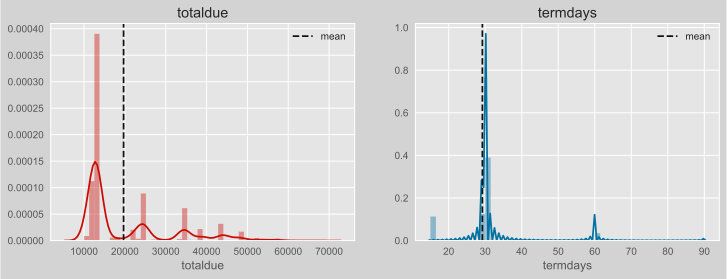

In [48]:
cols = ['totaldue', 'termdays']
length = len(cols)
cs = ["r","b"]

ax = plt.figure(figsize=(12,4))
ax.set_facecolor("lightgrey")
for i,j,k in itertools.zip_longest(cols,range(length),cs):
    plt.subplot(1,2,j+1)
    sns.distplot(app[app[i].notnull()][i],color=k)
    plt.axvline(app[i].mean(),label = "mean",linestyle="dashed",color="k")
    plt.legend(loc="best")
    plt.title(i)
    plt.subplots_adjust(hspace = .5)

#### 2 . EDA - loanamount,loannumber

In [49]:
print('Highest loan amount is:', app['loanamount'].max())
print('Lowest loan amount is:', app['loanamount'].min())
print('Average loan amount is:', app['loanamount'].mean())
print('Median loan amount is:', app['loanamount'].median())

Highest loan amount is: 60000.0
Lowest loan amount is: 10000.0
Average loan amount is: 17780.63264020164
Median loan amount is: 10000.0


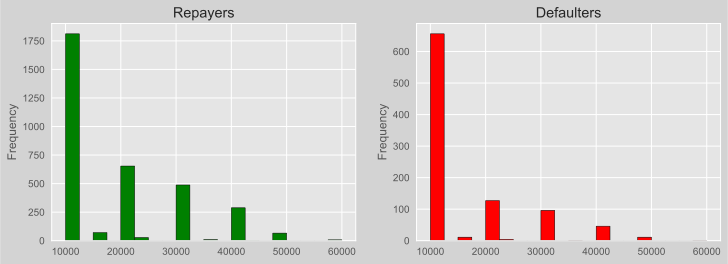

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
train[train['TARGET'] == 0].loanamount.plot.hist(
    ax=ax[0], bins=20, edgecolor='black', color='green')
ax[0].set_title('Repayers')
train[train['TARGET'] == 1].loanamount.plot.hist(
    ax=ax[1], color='red', bins=20, edgecolor='black')
ax[1].set_title('Defaulters')
fig.set_facecolor("lightgrey")
plt.show()

In [51]:
# Check and replace missing value
app['loanamount'].isnull().sum()

1102

In [52]:
app['loanamount'].fillna(app['loanamount'].median(), inplace=True)

---

In [53]:
print('Highest loan number is:', app['loannumber'].max())
print('Lowest loan number is:', app['loannumber'].min())
print('Average loan number is:', app['loannumber'].mean())
print('Median loan number is:', app['loannumber'].median())

Highest loan number is: 27.0
Lowest loan number is: 2.0
Average loan number is: 5.169922285234194
Median loan number is: 4.0


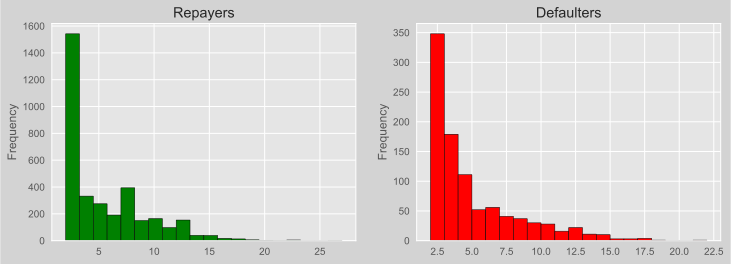

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
train[train['TARGET'] == 0].loannumber.plot.hist(
    ax=ax[0], bins=20, edgecolor='black', color='green')
ax[0].set_title('Repayers')
train[train['TARGET'] == 1].loannumber.plot.hist(
    ax=ax[1], color='red', bins=20, edgecolor='black')
ax[1].set_title('Defaulters')
fig.set_facecolor("lightgrey")
plt.show()

In [55]:
# Check and replace missing value
app['loannumber'].isnull().sum()

1102

In [56]:
app['loannumber'].fillna(app['loannumber'].median(), inplace=True)

#### 3 . EDA - latitude_gps,longitude_gps

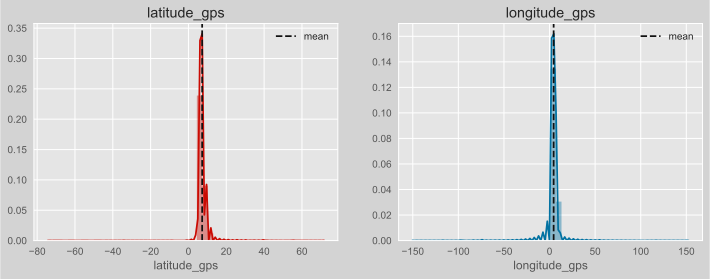

In [57]:
cols = ['latitude_gps', 'longitude_gps']
length = len(cols)
cs = ["r","b"]

ax = plt.figure(figsize=(12,4))
ax.set_facecolor("lightgrey")
for i,j,k in itertools.zip_longest(cols,range(length),cs):
    plt.subplot(1,2,j+1)
    sns.distplot(app[app[i].notnull()][i],color=k)
    plt.axvline(app[i].mean(),label = "mean",linestyle="dashed",color="k")
    plt.legend(loc="best")
    plt.title(i)
    plt.subplots_adjust(hspace = .5)

In [58]:
# Check and replace missing value
app['latitude_gps'].isnull().sum()

1099

In [59]:
app['latitude_gps'].fillna(app['latitude_gps'].mean(), inplace=True)
app['longitude_gps'].fillna(app['longitude_gps'].mean(), inplace=True)

#### 4 . EDA - employment_status_clients,bank_name_clients,bank_account_type

In [60]:
app["employment_status_clients"].value_counts()

Permanent        3422
Self-Employed     399
Student           158
Unemployed         65
Retired             8
Contract            2
Name: employment_status_clients, dtype: int64

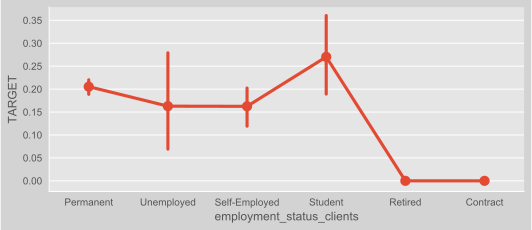

In [61]:
sns.factorplot('employment_status_clients','TARGET',data=train)
fig=plt.gcf()
fig.set_size_inches(8,3)
fig.set_facecolor("lightgrey")
plt.show()

In [62]:
# Check and replace missing value
app['employment_status_clients'].isnull().sum()

1809

In [63]:
app['employment_status_clients'].fillna(app['employment_status_clients'].mode(), inplace=True)

-------

In [64]:
app["bank_name_clients"].value_counts()

GT Bank               1745
First Bank             633
Access Bank            465
UBA                    379
Zenith Bank            336
                      ... 
Wema Bank               28
Heritage Bank           23
Keystone Bank           20
Standard Chartered      17
Unity Bank               7
Name: bank_name_clients, Length: 18, dtype: int64

**<font color="red">high cardinality for this variable. We will drop it**

In [65]:
app["bank_account_type"].value_counts()

Savings    3736
Other       958
Current      70
Name: bank_account_type, dtype: int64

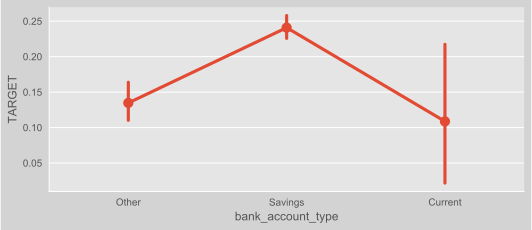

In [66]:
sns.factorplot('bank_account_type', 'TARGET',data=train)
fig=plt.gcf()
fig.set_size_inches(8, 3)
fig.set_facecolor("lightgrey")
plt.show()

In [67]:
# Check and replace missing value
app['bank_account_type'].isnull().sum()

1099

In [68]:
app['bank_account_type'].fillna(app['bank_account_type'].mode(), inplace=True)

#### 5 . EDA - approveddate,birthdate,creationdate

In [69]:
#Create Age from birthdate 
now = pd.Timestamp(dt.datetime.now())
app['Client_Age']  = (now - app['birthdate']).astype('<m8[Y]')

In [70]:
print('Oldest customer is:', app['Client_Age'].max())
print('Youngest customer is:', app['Client_Age'].min())
print('Average age is:', app['Client_Age'].mean())
print('Median age is:', app['Client_Age'].median())

Oldest customer is: 57.0
Youngest customer is: 22.0
Average age is: 34.02518891687657
Median age is: 33.0


In [71]:
app['Client_Age'].isnull().sum()

1099

In [72]:
app['Client_Age'].fillna(app['Client_Age'].median(), inplace=True)
app['Client_Age']  = app['Client_Age'].astype(int)

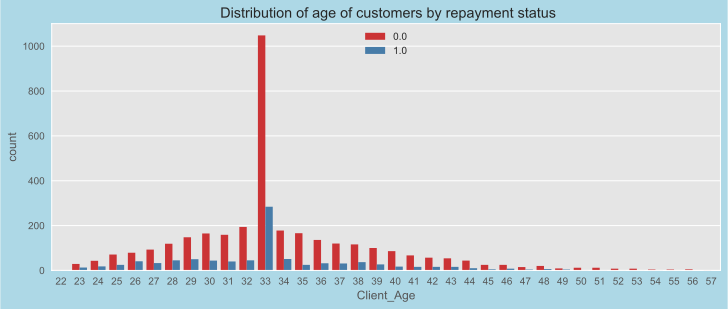

In [73]:
fig = plt.figure(figsize=(12,10))
plt.subplot(211)
sns.countplot(app["Client_Age"],palette="Set1",hue=app["TARGET"])
plt.legend(loc="upper center")
plt.title(" Distribution of age of customers by repayment status")
fig.set_facecolor("lightblue")

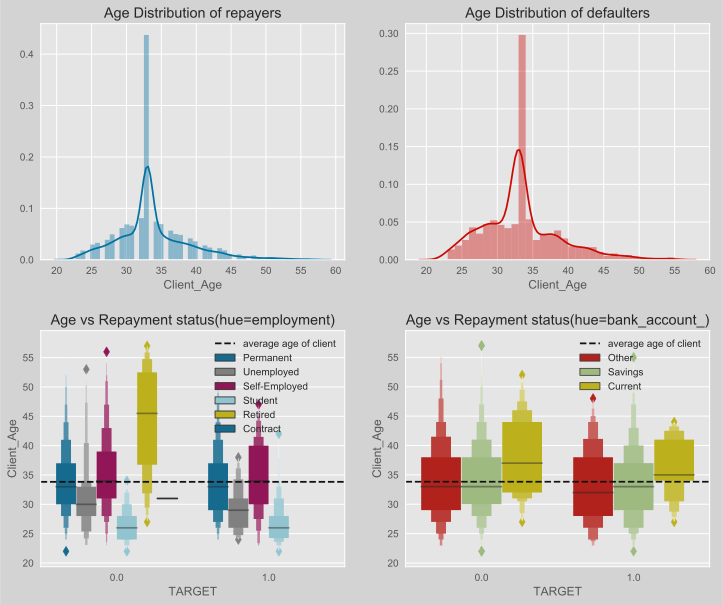

In [74]:
fig = plt.figure(figsize=(12,10))

plt.subplot(221)
sns.distplot(app[app["TARGET"]==0]["Client_Age"],color="b")
plt.title("Age Distribution of repayers")

plt.subplot(222)
sns.distplot(app[app["TARGET"]==1]["Client_Age"],color="r")
plt.title("Age Distribution of defaulters")

plt.subplot(223)
sns.lvplot(app["TARGET"],app["Client_Age"],hue=app["employment_status_clients"],palette=["b","grey","m","c","y"])
plt.axhline(app["Client_Age"].mean(),linestyle="dashed",color="k",label ="average age of client")
plt.legend(loc="best")
plt.title("Age vs Repayment status(hue=employment)")

plt.subplot(224)
sns.lvplot(app["TARGET"],app["Client_Age"],hue=app["bank_account_type"],palette=["r","g","y"])
plt.axhline(app["Client_Age"].mean(),linestyle="dashed",color="k",label ="average age of client")
plt.legend(loc="best")
plt.title("Age vs Repayment status(hue=bank_account_)")

plt.subplots_adjust(wspace = .2,hspace = .3)

fig.set_facecolor("lightgrey")

In [75]:
#Get the time difference between approval and creation
app['process_time'] = app['approveddate'] - app['creationdate']

In [85]:
display(app.head(3))

TARGET        approveddate bank_account_type bank_name_clients  birthdate  \
0    0.00 2017-07-25 08:22:56             Other      Diamond Bank 1972-01-15   
1    0.00 2017-07-05 17:04:41           Savings           GT Bank 1985-08-23   
2    0.00 2017-07-06 14:52:57             Other           EcoBank 1984-09-18   

         creationdate                        customerid  \
0 2017-07-25 07:22:47  8a2a81a74ce8c05d014cfb32a0da1049   
1 2017-07-05 16:04:18  8a85886e54beabf90154c0a29ae757c0   
2 2017-07-06 13:52:51  8a8588f35438fe12015444567666018e   

  employment_status_clients good_bad_flag  latitude_gps  loanamount  \
0                 Permanent          Good          6.43   30,000.00   
1                 Permanent          Good          7.32   15,000.00   
2                 Permanent          Good         10.29   20,000.00   

   loannumber  longitude_gps    set   systemloanid  termdays  totaldue  \
0       12.00           3.43  train 301,994,762.00     30.00 34,500.00   
1        2.00           3.88  train 301,965,204.00     30.00 17,250.00   
2        7.00          11.14  train 301,966,580.00     15.00 22,250.00   

   Client_Age  process_time  approveddate_year  approveddate_month  \
0          47            60           2,017.00                7.00   
1          33            60           2,017.00                7.00   
2          34            60           2,017.00                7.00   

   approveddate_day approveddate_weekday  approveddate_hour  
0             25.00              Tuesday               8.00  
1              5.00            Wednesday              17.00  
2              6.00             Thursday              14.00

In [79]:
app['approveddate_year']  = app['approveddate'].dt.year
app['approveddate_month'] = app['approveddate'].dt.month
app['approveddate_day']   = app['approveddate'].dt.day
app['approveddate_weekday']   = app['approveddate'].dt.day_name()

In [81]:
app['approveddate_hour'] = pd.DatetimeIndex(app['approveddate']).hour

In [83]:
#replace missing data with o
app['process_time'].fillna(0, inplace=True)

In [84]:
#convert processed time to time delta
app['process_time'] = pd.to_timedelta(app['process_time']).astype('timedelta64[m]').astype(int)

### Drop high cardinality variable

In [86]:
#drop the bank_name_clients and birthdate
columns = ['bank_name_clients','birthdate','good_bad_flag','creationdate','approveddate']
app.drop(columns, inplace=True, axis=1)

### Dummify Categorical Variables

In [87]:
#Dummify the variables
# Encoding categorical variables
# create three dummy variables using get_dummies, then exclude the first dummy column
def dummify(col_name, df):
    df_dummies = pd.get_dummies(df[col_name], prefix=col_name).iloc[:, 1:] 
    return df_dummies 

In [88]:
#call the function
dummy_cols = ['bank_account_type','employment_status_clients','approveddate_weekday']
for col_name in dummy_cols:
    dummies = dummify(col_name, app)
    app = pd.concat([app, dummies], axis=1) # join the dummy columns to the original df
    app = app.drop([col_name], axis=1) # drop the original cat. vars column

In [90]:
display(app.head(3))

TARGET                        customerid  latitude_gps  loanamount  \
0    0.00  8a2a81a74ce8c05d014cfb32a0da1049          6.43   30,000.00   
1    0.00  8a85886e54beabf90154c0a29ae757c0          7.32   15,000.00   
2    0.00  8a8588f35438fe12015444567666018e         10.29   20,000.00   

   loannumber  longitude_gps    set   systemloanid  termdays  totaldue  \
0       12.00           3.43  train 301,994,762.00     30.00 34,500.00   
1        2.00           3.88  train 301,965,204.00     30.00 17,250.00   
2        7.00          11.14  train 301,966,580.00     15.00 22,250.00   

   Client_Age  process_time  approveddate_year  approveddate_month  \
0          47            60           2,017.00                7.00   
1          33            60           2,017.00                7.00   
2          34            60           2,017.00                7.00   

   approveddate_day  approveddate_hour  bank_account_type_Other  \
0             25.00               8.00                        1   
1              5.00              17.00                        0   
2              6.00              14.00                        1   

   bank_account_type_Savings  employment_status_clients_Permanent  \
0                          0                                    1   
1                          1                                    1   
2                          0                                    1   

   employment_status_clients_Retired  employment_status_clients_Self-Employed  \
0                                  0                                        0   
1                                  0                                        0   
2                                  0                                        0   

   employment_status_clients_Student  employment_status_clients_Unemployed  \
0                                  0                                     0   
1                                  0                                     0   
2                                  0                                     0   

   approveddate_weekday_Monday  approveddate_weekday_Saturday  \
0                            0                              0   
1                            0                              0   
2                            0                              0   

   approveddate_weekday_Sunday  approveddate_weekday_Thursday  \
0                            0                              0   
1                            0                              0   
2                            0                              1   

   approveddate_weekday_Tuesday  approveddate_weekday_Wednesday  
0                             1                               0  
1                             0                               1  
2                             0                               0

In [91]:
#Export the data
app.to_csv('../data/interim/app.csv', index=False)
app_prev.to_csv('../data/interim/app_prev.csv', index=False)

**<font color="red">Variables to be dropped : good_bad_flag,set,systemloanid. Used for modeliing : TARGET,customerid**

---

## FEATURE ENGINEERING

### Manual Feature Engineering

In [92]:
display(app_prev.tail(3))

customerid  systemloanid  loannumber  \
24087  8a858fab5b9105dc015b975e594e394a     301952446           1   
24088  8a858fcf5b39c3ba015b39c7691603e1     301887884           2   
24089  8a858e165cf9d8e3015cfffb0c61459f     301959483           1   

             approveddate        creationdate  loanamount  totaldue  termdays  \
24087 2017-06-26 15:46:28 2017-06-26 14:45:20   10,000.00 13,000.00        30   
24088 2017-05-03 06:56:10 2017-05-03 05:56:04   10,000.00 13,000.00        30   
24089 2017-07-01 22:23:15 2017-07-01 21:22:08   10,000.00 13,000.00        30   

               closeddate firstduedate     firstrepaiddate   set  
24087 2017-07-13 13:12:43   2017-07-26 2017-07-13 13:02:34  test  
24088 2017-06-01 22:00:17   2017-06-02 2017-06-01 21:50:07  test  
24089 2017-07-29 14:25:20   2017-07-31 2017-07-29 14:15:11  test

In [93]:
display(app.tail(3))

TARGET                        customerid  latitude_gps  loanamount  \
5860     nan  8a858e8b5bc9e7e6015bcd7374077f0c          6.46   10,000.00   
5861     nan  8a858f2e5c699f3a015c77aa22ed7f23          7.11   10,000.00   
5862     nan  8a858fde580afd48015818eda53830c8          6.56   10,000.00   

      loannumber  longitude_gps   set  systemloanid  termdays  totaldue  \
5860        4.00           3.43  test           nan     29.22 13,000.00   
5861        4.00           3.32  test           nan     29.22 13,000.00   
5862        4.00           3.37  test           nan     29.22 13,000.00   

      Client_Age  process_time  approveddate_year  approveddate_month  \
5860          30             0                nan                 nan   
5861          44             0                nan                 nan   
5862          31             0                nan                 nan   

      approveddate_day  approveddate_hour  bank_account_type_Other  \
5860               nan                nan                        0   
5861               nan                nan                        0   
5862               nan                nan                        0   

      bank_account_type_Savings  employment_status_clients_Permanent  \
5860                          1                                    1   
5861                          1                                    1   
5862                          1                                    1   

      employment_status_clients_Retired  \
5860                                  0   
5861                                  0   
5862                                  0   

      employment_status_clients_Self-Employed  \
5860                                        0   
5861                                        0   
5862                                        0   

      employment_status_clients_Student  employment_status_clients_Unemployed  \
5860                                  0                                     0   
5861                                  0                                     0   
5862                                  0                                     0   

      approveddate_weekday_Monday  approveddate_weekday_Saturday  \
5860                            0                              0   
5861                            0                              0   
5862                            0                              0   

      approveddate_weekday_Sunday  approveddate_weekday_Thursday  \
5860                            0                              0   
5861                            0                              0   
5862                            0                              0   

      approveddate_weekday_Tuesday  approveddate_weekday_Wednesday  
5860                             0                               0  
5861                             0                               0  
5862                             0                               0

In [94]:
#create interest variable
app['interest'] = app['totaldue'] - app['loanamount']
app.head()

TARGET                        customerid  latitude_gps  loanamount  \
0    0.00  8a2a81a74ce8c05d014cfb32a0da1049          6.43   30,000.00   
1    0.00  8a85886e54beabf90154c0a29ae757c0          7.32   15,000.00   
2    0.00  8a8588f35438fe12015444567666018e         10.29   20,000.00   
3    0.00  8a85890754145ace015429211b513e16          7.49   10,000.00   
4    0.00  8a858970548359cc0154883481981866          9.08   40,000.00   

   loannumber  longitude_gps    set   systemloanid  termdays  totaldue  \
0       12.00           3.43  train 301,994,762.00     30.00 34,500.00   
1        2.00           3.88  train 301,965,204.00     30.00 17,250.00   
2        7.00          11.14  train 301,966,580.00     15.00 22,250.00   
3        3.00           3.99  train 301,999,343.00     15.00 11,500.00   
4        9.00           7.46  train 301,962,360.00     30.00 44,000.00   

   Client_Age  process_time  approveddate_year  approveddate_month  \
0          47            60           2,017.00                7.00   
1          33            60           2,017.00                7.00   
2          34            60           2,017.00                7.00   
3          41            60           2,017.00                7.00   
4          32            60           2,017.00                7.00   

   approveddate_day  approveddate_hour  bank_account_type_Other  \
0             25.00               8.00                        1   
1              5.00              17.00                        0   
2              6.00              14.00                        1   
3             27.00              19.00                        0   
4              3.00              23.00                        1   

   bank_account_type_Savings  employment_status_clients_Permanent  \
0                          0                                    1   
1                          1                                    1   
2                          0                                    1   
3                          1                                    1   
4                          0                                    1   

   employment_status_clients_Retired  employment_status_clients_Self-Employed  \
0                                  0                                        0   
1                                  0                                        0   
2                                  0                                        0   
3                                  0                                        0   
4                                  0                                        0   

   employment_status_clients_Student  employment_status_clients_Unemployed  \
0                                  0                                     0   
1                                  0                                     0   
2                                  0                                     0   
3                                  0                                     0   
4                                  0                                     0   

   approveddate_weekday_Monday  approveddate_weekday_Saturday  \
0                            0                              0   
1                            0                              0   
2                            0                              0   
3                            0                              0   
4                            1                              0   

   approveddate_weekday_Sunday  approveddate_weekday_Thursday  \
0                            0                              0   
1                            0                              0   
2                            0                              1   
3                            0                              1   
4                            0                              0   

   approveddate_weekday_Tuesday  approveddate_weekday_Wednesday  interest  
0                             1                               0  4

In [101]:
app2 = app.drop_duplicates(subset='customerid',keep='last')
app2.shape

(4753, 30)

In [95]:
app_prev['first_pay_diff'] = app_prev['firstduedate'] - app_prev['firstrepaiddate']
app_prev['repay_day'] = app_prev['closeddate'] - app_prev['approveddate']
display(app_prev.head(3))

customerid  systemloanid  loannumber  \
0  8a2a81a74ce8c05d014cfb32a0da1049     301682320           2   
1  8a2a81a74ce8c05d014cfb32a0da1049     301883808           9   
2  8a2a81a74ce8c05d014cfb32a0da1049     301831714           8   

         approveddate        creationdate  loanamount  totaldue  termdays  \
0 2016-08-15 18:22:40 2016-08-15 17:22:32   10,000.00 13,000.00        30   
1 2017-04-28 18:39:07 2017-04-28 17:38:53   10,000.00 13,000.00        30   
2 2017-03-05 10:56:25 2017-03-05 09:56:19   20,000.00 23,800.00        30   

           closeddate firstduedate     firstrepaiddate    set  \
0 2016-09-01 16:06:48   2016-09-14 2016-09-01 15:51:43  train   
1 2017-05-28 14:44:49   2017-05-30 2017-05-26 00:00:00  train   
2 2017-04-26 22:18:56   2017-04-04 2017-04-26 22:03:47  train   

      first_pay_diff        repay_day  
0   12 days 08:08:17 16 days 21:44:08  
1    4 days 00:00:00 29 days 20:05:42  
2 -23 days +01:56:13 52 days 11:22:31

In [96]:
app_prev['first_pay_diff'] = pd.to_timedelta(app_prev['first_pay_diff']).astype('timedelta64[m]').astype(int)
app_prev['repay_day'] = pd.to_timedelta(app_prev['repay_day']).astype('timedelta64[m]').astype(int)
display(app_prev.head(3))

customerid  systemloanid  loannumber  \
0  8a2a81a74ce8c05d014cfb32a0da1049     301682320           2   
1  8a2a81a74ce8c05d014cfb32a0da1049     301883808           9   
2  8a2a81a74ce8c05d014cfb32a0da1049     301831714           8   

         approveddate        creationdate  loanamount  totaldue  termdays  \
0 2016-08-15 18:22:40 2016-08-15 17:22:32   10,000.00 13,000.00        30   
1 2017-04-28 18:39:07 2017-04-28 17:38:53   10,000.00 13,000.00        30   
2 2017-03-05 10:56:25 2017-03-05 09:56:19   20,000.00 23,800.00        30   

           closeddate firstduedate     firstrepaiddate    set  first_pay_diff  \
0 2016-09-01 16:06:48   2016-09-14 2016-09-01 15:51:43  train           17768   
1 2017-05-28 14:44:49   2017-05-30 2017-05-26 00:00:00  train            5760   
2 2017-04-26 22:18:56   2017-04-04 2017-04-26 22:03:47  train          -33004   

   repay_day  
0      24344  
1      42965  
2      75562

In [97]:
#create interest variable
app_prev['interest'] = app_prev['totaldue'] - app_prev['loanamount']

In [98]:
app_prev['approveddate_year']      = app_prev['approveddate'].dt.year
app_prev['approveddate_month']     = app_prev['approveddate'].dt.month
app_prev['approveddate_day']       = app_prev['approveddate'].dt.day
app_prev['approveddate_weekday']   = app_prev['approveddate'].dt.day_name()
app_prev['approveddate_hour']      = pd.DatetimeIndex(app_prev['approveddate']).hour

In [99]:
#drop columns
columns = ['approveddate','creationdate','firstduedate','closeddate','firstrepaiddate']
app_prev.drop(columns, inplace=True, axis=1)

In [100]:
display(app_prev.head(3))

customerid  systemloanid  loannumber  loanamount  \
0  8a2a81a74ce8c05d014cfb32a0da1049     301682320           2   10,000.00   
1  8a2a81a74ce8c05d014cfb32a0da1049     301883808           9   10,000.00   
2  8a2a81a74ce8c05d014cfb32a0da1049     301831714           8   20,000.00   

   totaldue  termdays    set  first_pay_diff  repay_day  interest  \
0 13,000.00        30  train           17768      24344  3,000.00   
1 13,000.00        30  train            5760      42965  3,000.00   
2 23,800.00        30  train          -33004      75562  3,800.00   

   approveddate_year  approveddate_month  approveddate_day  \
0               2016                   8                15   
1               2017                   4                28   
2               2017                   3                 5   

  approveddate_weekday  approveddate_hour  
0               Monday                 18  
1               Friday                 18  
2               Sunday                 10

In [103]:
# Groupby the client id (customerid), count the number of previous loans, and rename the column
previous_loan_counts = app_prev.groupby('customerid', as_index=False)['systemloanid'].count().rename(columns = {'systemloanid': 'previous_loan_counts'})
previous_loan_counts.head()

customerid  previous_loan_counts
0  8a1088a0484472eb01484669e3ce4e0b                     1
1  8a1a1e7e4f707f8b014f797718316cad                     4
2  8a1a32fc49b632520149c3b8fdf85139                     7
3  8a1eb5ba49a682300149c3c068b806c7                     8
4  8a1edbf14734127f0147356fdb1b1eb2                     2

In [104]:
# Join to the training dataframe

app_prev = app_prev.merge(previous_loan_counts, on = 'customerid', how = 'left')

# Fill the missing values with 0 
app_prev['previous_loan_counts'] = app_prev['previous_loan_counts'].fillna(0)
app_prev.head(3)

customerid  systemloanid  loannumber  loanamount  \
0  8a2a81a74ce8c05d014cfb32a0da1049     301682320           2   10,000.00   
1  8a2a81a74ce8c05d014cfb32a0da1049     301883808           9   10,000.00   
2  8a2a81a74ce8c05d014cfb32a0da1049     301831714           8   20,000.00   

   totaldue  termdays    set  first_pay_diff  repay_day  interest  \
0 13,000.00        30  train           17768      24344  3,000.00   
1 13,000.00        30  train            5760      42965  3,000.00   
2 23,800.00        30  train          -33004      75562  3,800.00   

   approveddate_year  approveddate_month  approveddate_day  \
0               2016                   8                15   
1               2017                   4                28   
2               2017                   3                 5   

  approveddate_weekday  approveddate_hour  previous_loan_counts  
0               Monday                 18                    11  
1               Friday                 18                    11  
2               Sunday                 10                    11

In [105]:
## Aggregating Numeric Columns
# Group by the client id, calculate aggregation statistics
app_prev_agg = app_prev.drop(columns = ['systemloanid']).groupby('customerid', as_index = False).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
app_prev_agg.head(3)

customerid loannumber                    loanamount  \
                                         count mean max min   sum      count   
0  8a1088a0484472eb01484669e3ce4e0b          1 1.00   1   1  1.00          1   
1  8a1a1e7e4f707f8b014f797718316cad          4 2.50   4   1 10.00          4   
2  8a1a32fc49b632520149c3b8fdf85139          7 4.00   7   1 28.00          7   

                                          totaldue                      \
       mean       max       min       sum    count      mean       max   
0 10,000.00 10,000.00 10,000.00 10,000.00        1 11,500.00 11,500.00   
1 17,504.00 30,000.00 10,000.00       inf        4 22,375.00 39,000.00   
2 12,856.00 20,000.00 10,000.00       inf        7 15,214.29 24,500.00   

                       termdays                      first_pay_diff            \
        min        sum    count  mean max min    sum          count      mean   
0 11,500.00  11,500.00        1 15.00  15  15  15.00              1 -9,881.00   
1 13,000.00  89,500.00        4 37.50  60  30 150.00              4   -560.00   
2 11,500.00 106,500.00        7 19.29  30  15 135.00              7   -182.71   

                    repay_day                                 interest  \
    max   min   sum     count      mean    max    min     sum    count   
0 -9881 -9881 -9881         1 31,771.00  31771  31771   31771        1   
1   534 -2082 -2240         4 45,605.75  50258  42216  182423        4   
2  2412 -2169 -1279         7 27,137.86  43662  20137  189965        7   

                                       approveddate_year                       \
      mean      max      min       sum             count     mean   max   min   
0 1,500.00 1,500.00 1,500.00  1,500.00                 1 2,017.00  2017  2017   
1 4,875.00 9,000.00 3,000.00 19,500.00                 4 2,016.50  2017  2016   
2 2,357.14 4,500.00 1,500.00 16,500.00                 7 2,016.86  2017  2016   

         approveddate_month                  approveddate_day                \
     sum              count mean max min sum            count  mean max min   
0   2017                  1 7.00   7   7   7                1  2.00   2   2   
1   8066                  4 5.50   6   5  22                4 18.00  23  13   
2  14118                  7 4.00   6   2  28                7 16.43  28   2   

       approveddate_hour                    previous_loan_counts               \
   sum             count  mean max min  sum                count mean max min   
0    2                 1 19.00  19  19   19                    1    1   1   1   
1   72                 4 15.50  22  11   62                    4    4   4   4   
2  115                 7 15.00  19  11  105                    7    7   7   7   

       
  sum  
0   1  
1  16  
2  49

We need to create new names for each of these columns. The following code makes new names by appending the stat to the name. Here we have to deal with the fact that the dataframe has a multi-level index. I find these confusing and hard to work with, so I try to reduce to a single level index as quickly as possible.

In [108]:
# List of column names
columns = ['customerid']

# Iterate through the variables names
for var in app_prev_agg.columns.levels[0]:
    # Skip the id name
    if var != 'customerid':
        
        # Iterate through the stat names
        for stat in app_prev_agg.columns.levels[1][:-1]:
            # Make a new column name for the variable and stat
            columns.append('previous%s_%s' % (var, stat))

In [109]:
# Assign the list of columns names as the dataframe column names
app_prev_agg.columns = columns
app_prev_agg.head(3)

customerid  previousloannumber_count  \
0  8a1088a0484472eb01484669e3ce4e0b                         1   
1  8a1a1e7e4f707f8b014f797718316cad                         4   
2  8a1a32fc49b632520149c3b8fdf85139                         7   

   previousloannumber_mean  previousloannumber_max  previousloannumber_min  \
0                     1.00                       1                       1   
1                     2.50                       4                       1   
2                     4.00                       7                       1   

   previousloannumber_sum  previousloanamount_count  previousloanamount_mean  \
0                    1.00                         1                10,000.00   
1                   10.00                         4                17,504.00   
2                   28.00                         7                12,856.00   

   previousloanamount_max  previousloanamount_min  previousloanamount_sum  \
0               10,000.00               10,000.00               10,000.00   
1               30,000.00               10,000.00                     inf   
2               20,000.00               10,000.00                     inf   

   previoustotaldue_count  previoustotaldue_mean  previoustotaldue_max  \
0                       1              11,500.00             11,500.00   
1                       4              22,375.00             39,000.00   
2                       7              15,214.29             24,500.00   

   previoustotaldue_min  previoustotaldue_sum  previoustermdays_count  \
0             11,500.00             11,500.00                       1   
1             13,000.00             89,500.00                       4   
2             11,500.00            106,500.00                       7   

   previoustermdays_mean  previoustermdays_max  previoustermdays_min  \
0                  15.00                    15                    15   
1                  37.50                    60                    30   
2                  19.29                    30                    15   

   previoustermdays_sum  previousfirst_pay_diff_count  \
0                 15.00                             1   
1                150.00                             4   
2                135.00                             7   

   previousfirst_pay_diff_mean  previousfirst_pay_diff_max  \
0                    -9,881.00                       -9881   
1                      -560.00                         534   
2                      -182.71                        2412   

   previousfirst_pay_diff_min  previousfirst_pay_diff_sum  \
0                       -9881                       -9881   
1                       -2082                       -2240   
2                       -2169                       -1279   

   previousrepay_day_count  previousrepay_day_mean  previousrepay_day_max  \
0                        1               31,771.00                  31771   
1                        4               45,605.75                  50258   
2                        7               27,137.86                  43662   

   previousrepay_day_min  previousrepay_day_sum  previousinterest_count  \
0                  31771                  31771                       1   
1                  42216                 182423                       4   
2                  20137                 189965                       7   

   previousinterest_mean  previousinterest_max  previousinterest_min  \
0               1,500.00              1,500.00              1,500.00   
1               4,875.00              9,000.00              3,000.00   
2               2,357.14              4,500.00              1,500.00   

   previousinterest_sum  previousapproveddate_year_count  \
0              1,500.00                                1   
1             19,500.00                                4   
2             16,500.00                                7   

   previousapproveddate_year_mean  previousapproveddate_year_max  \
0          

Now we simply merge with the training data as we did before.

In [110]:
# Merge with the training data
app_prev = app_prev.merge(app_prev_agg, on = 'customerid', how = 'left')
app_prev.head()

customerid  systemloanid  loannumber  loanamount  \
0  8a2a81a74ce8c05d014cfb32a0da1049     301682320           2   10,000.00   
1  8a2a81a74ce8c05d014cfb32a0da1049     301883808           9   10,000.00   
2  8a2a81a74ce8c05d014cfb32a0da1049     301831714           8   20,000.00   
3  8a8588f35438fe12015444567666018e     301861541           5   10,000.00   
4  8a85890754145ace015429211b513e16     301941754           2   10,000.00   

   totaldue  termdays    set  first_pay_diff  repay_day  interest  \
0 13,000.00        30  train           17768      24344  3,000.00   
1 13,000.00        30  train            5760      42965  3,000.00   
2 23,800.00        30  train          -33004      75562  3,800.00   
3 11,500.00        15  train             -49      20589  1,500.00   
4 11,500.00        15  train          -17109      39588  1,500.00   

   approveddate_year  approveddate_month  approveddate_day  \
0               2016                   8                15   
1               2017                   4                28   
2               2017                   3                 5   
3               2017                   4                 9   
4               2017                   6                17   

  approveddate_weekday  approveddate_hour  previous_loan_counts  \
0               Monday                 18                    11   
1               Friday                 18                    11   
2               Sunday                 10                    11   
3               Sunday                 18                     6   
4             Saturday                  9                     2   

   previousloannumber_count  previousloannumber_mean  previousloannumber_max  \
0                        11                     6.00                      11   
1                        11                     6.00                      11   
2                        11                     6.00                      11   
3                         6                     3.50                       6   
4                         2                     1.50                       2   

   previousloannumber_min  previousloannumber_sum  previousloanamount_count  \
0                       1                   66.00                        11   
1                       1                   66.00                        11   
2                       1                   66.00                        11   
3                       1                   21.00                         6   
4                       1                    3.00                         2   

   previousloanamount_mean  previousloanamount_max  previousloanamount_min  \
0                18,176.00               30,000.00               10,000.00   
1                18,176.00               30,000.00               10,000.00   
2                18,176.00               30,000.00               10,000.00   
3                10,000.00               10,000.00               10,000.00   
4                10,000.00               10,000.00               10,000.00   

   previousloanamount_sum  previoustotaldue_count  previoustotaldue_mean  \
0                     inf                      11              22,081.82   
1                     inf                      11              22,081.82   
2                     inf                      11              22,081.82   
3               60,000.00                       6              11,750.00   
4               20,000.00                       2              12,250.00   

   previoustotaldue_max  previoustotaldue_min  previoustotaldue_sum  \
0             34,500.00             13,000.00            242,900.00   
1             34,500.00             13,000.00            242,900.00   
2             34,500.00             13,000.00            242,900.00   
3             13,000.00             11,500.00             70,500.00   
4             13,000.00             11,500.00             24,500.00   

   previoustermdays_count  previoustermdays_mean  previousterm

In [116]:
app_prev.head(3)

customerid  systemloanid  loannumber  loanamount  \
0  8a2a81a74ce8c05d014cfb32a0da1049     301682320           2   10,000.00   
1  8a2a81a74ce8c05d014cfb32a0da1049     301883808           9   10,000.00   
2  8a2a81a74ce8c05d014cfb32a0da1049     301831714           8   20,000.00   

   totaldue  termdays    set  first_pay_diff  repay_day  interest  \
0 13,000.00        30  train           17768      24344  3,000.00   
1 13,000.00        30  train            5760      42965  3,000.00   
2 23,800.00        30  train          -33004      75562  3,800.00   

   approveddate_year  approveddate_month  approveddate_day  \
0               2016                   8                15   
1               2017                   4                28   
2               2017                   3                 5   

  approveddate_weekday  approveddate_hour  previous_loan_counts  \
0               Monday                 18                    11   
1               Friday                 18                    11   
2               Sunday                 10                    11   

   previousloannumber_count  previousloannumber_mean  previousloannumber_max  \
0                        11                     6.00                      11   
1                        11                     6.00                      11   
2                        11                     6.00                      11   

   previousloannumber_min  previousloannumber_sum  previousloanamount_count  \
0                       1                   66.00                        11   
1                       1                   66.00                        11   
2                       1                   66.00                        11   

   previousloanamount_mean  previousloanamount_max  previousloanamount_min  \
0                18,176.00               30,000.00               10,000.00   
1                18,176.00               30,000.00               10,000.00   
2                18,176.00               30,000.00               10,000.00   

   previousloanamount_sum  previoustotaldue_count  previoustotaldue_mean  \
0                     inf                      11              22,081.82   
1                     inf                      11              22,081.82   
2                     inf                      11              22,081.82   

   previoustotaldue_max  previoustotaldue_min  previoustotaldue_sum  \
0             34,500.00             13,000.00            242,900.00   
1             34,500.00             13,000.00            242,900.00   
2             34,500.00             13,000.00            242,900.00   

   previoustermdays_count  previoustermdays_mean  previoustermdays_max  \
0                      11                  30.00                    30   
1                      11                  30.00                    30   
2                      11                  30.00                    30   

   previoustermdays_min  previoustermdays_sum  previousfirst_pay_diff_count  \
0                    30                330.00                            11   
1                    30                330.00                            11   
2                    30                330.00                            11   

   previousfirst_pay_diff_mean  previousfirst_pay_diff_max  \
0                       552.18                       40669   
1                       552.18                       40669   
2                       552.18                       40669   

   previousfirst_pay_diff_min  previousfirst_pay_diff_sum  \
0                      -56946                        6074   
1                      -56946                        6074   
2                      -56946                        6074   

   previousrepay_day_count  previousrepay_day_mean  previousrepay_day_max  \
0                       11               43,148.00                  99016   
1                       11               43,148.00                  99016   
2                       11               

In [117]:
#Dummify the variables
# Encoding categorical variables
# create three dummy variables using get_dummies, then exclude the first dummy column
def dummify(col_name, df):
    df_dummies = pd.get_dummies(df[col_name], prefix=col_name).iloc[:, 1:] 
    return df_dummies 

In [119]:
#call the function
dummy_cols = ['approveddate_weekday']
for col_name in dummy_cols:
    dummies = dummify(col_name, app_prev)
    app_prev = pd.concat([app_prev, dummies], axis=1) # join the dummy columns to the original df
    app_prev = app_prev.drop([col_name], axis=1) # drop the original cat. vars column

In [120]:
print(app.shape)
print(app_prev.shape)

(4753, 30)
(24090, 99)


In [121]:
train_df = app[app['set'] == 'train']
test_df  = app[app['set'] == 'test']

In [122]:
train_df_prev = app_prev[app_prev['set'] == 'train']
test__df_prev  = app_prev[app_prev['set'] == 'test']

In [123]:
# Check The Shape Of The Data Loaded
print('Train Demographic shape: {} Rows, {} Columns'.format(*train_df.shape))
print('Test Performance shape: {} Rows, {} Columns'.format(*test_df.shape))
print('Train Previous Loan shape: {} Rows, {} Columns'.format(*train_df_prev.shape))
print('Test Demographic shape: {} Rows, {} Columns'.format(*test__df_prev.shape))

Train Demographic shape: 3269 Rows, 30 Columns
Test Performance shape: 1484 Rows, 30 Columns
Train Previous Loan shape: 18183 Rows, 99 Columns
Test Demographic shape: 5907 Rows, 99 Columns


In [129]:
#columns to merge to the train set
columns = ['systemloanid','loannumber','loanamount','totaldue','termdays','first_pay_diff','repay_day','interest','approveddate_year','approveddate_month',
           'approveddate_day','approveddate_weekday','approveddate_hour']
app_prev2 = app_prev.drop(columns, axis=1)

KeyError: "['systemloanid' 'loannumber' 'loanamount' 'totaldue' 'termdays'\n 'first_pay_diff' 'repay_day' 'interest' 'approveddate_year'\n 'approveddate_month' 'approveddate_day' 'approveddate_weekday'\n 'approveddate_hour'] not found in axis"

In [130]:
app_prev2.head(3)

AttributeError: 'NoneType' object has no attribute 'head'

In [131]:
data = pd.merge(app, app_prev, how='outer', on=['customerid'])

---

## FEATURE SELECTION

### Correlation

In [132]:
#calculate corelations
correlation =  data.corr()
correlation.to_csv('../data/interim/correlations.csv')

In [133]:
correlations = pd.read_csv('../data/interim/correlations.csv', index_col =0)
correlations.index.name = 'Variable'
correlations.head()

TARGET  latitude_gps  loanamount  loannumber  longitude_gps  \
Variable                                                                     
TARGET           1.00          0.01       -0.11       -0.08           0.01   
latitude_gps     0.01          1.00        0.03        0.03          -0.29   
loanamount      -0.11          0.03        1.00        0.82           0.00   
loannumber      -0.08          0.03        0.82        1.00          -0.03   
longitude_gps    0.01         -0.29        0.00       -0.03           1.00   

               systemloanid  termdays  totaldue  Client_Age  process_time  \
Variable                                                                    
TARGET                -0.02     -0.01     -0.10       -0.06          0.02   
latitude_gps          -0.01     -0.01      0.02       -0.04          0.00   
loanamount            -0.02      0.52      0.99        0.01          0.33   
loannumber            -0.01      0.34      0.80       -0.02          0.28   
longitude_gps         -0.05      0.01      0.00        0.01          0.01   

               approveddate_year  approveddate_month  approveddate_day  \
Variable                                                                 
TARGET                       nan                 nan             -0.02   
latitude_gps               -0.01               -0.01             -0.02   
loanamount                  0.02                0.02             -0.01   
loannumber                  0.01                0.01             -0.01   
longitude_gps               0.02                0.02             -0.03   

               approveddate_hour  bank_account_type_Other  \
Variable                                                    
TARGET                     -0.03                    -0.11   
latitude_gps               -0.03                     0.00   
loanamount                 -0.00                     0.28   
loannumber                 -0.01                     0.37   
longitude_gps               0.02                    -0.01   

               bank_account_type_Savings  employment_status_clients_Permanent  \
Variable                                                                        
TARGET                              0.12                                -0.02   
latitude_gps                       -0.00                                 0.03   
loanamount                         -0.27                                -0.10   
loannumber                         -0.37                                -0.13   
longitude_gps                       0.01                                 0.02   

               employment_status_clients_Retired  \
Variable                                           
TARGET                                     -0.02   
latitude_gps                               -0.02   
loanamount                                 -0.00   
loannumber                                  0.01   
longitude_gps                               0.00   

               employment_status_clients_Self-Employed  \
Variable                                                 
TARGET                                           -0.04   
latitude_gps                                     -0.03   
loanamount                                        0.21   
loannumber                                        0.26   
longitude_gps                                    -0.00   

               employment_status_clients_Student  \
Variable                                           
TARGET                                      0.02   
latitude_gps                                0.03   
loanamount                                  0.03   
loannumber                                  0.05   
longitude_gps                              -0.04   

               employment_status_clients_Unemployed  \
Variable                                              
TARGET                                        -0.00   
latitude_gps                                  -0.02   
loanamount                                    -0.01   
l

In [134]:
#correlation with target
correlations_target = correlations.sort_values('TARGET')['TARGET']
# Most negative correlations
correlations_target.head(5)

Variable
previousfirst_pay_diff_mean   -0.18
previousfirst_pay_diff_min    -0.15
previoustotaldue_max          -0.12
previousloanamount_max        -0.12
previousfirst_pay_diff_sum    -0.11
Name: TARGET, dtype: float64

In [135]:
# Most positive correlations
correlations_target.dropna().tail(5)

Variable
previousapproveddate_month_min   0.07
previousrepay_day_max            0.07
previousrepay_day_mean           0.10
bank_account_type_Savings        0.12
TARGET                           1.00
Name: TARGET, dtype: float64

##### Visualize Distribution of Correlated Variables

In [136]:
def kde_target_plot(df, feature):
    """Kernel density estimate plot of a feature colored
    by value of the target."""
    
    # Need to reset index for loc to workBU
    df = df.reset_index()
    plt.figure(figsize = (10, 6))
    plt.style.use('fivethirtyeight')
    
    # plot repaid loans
    sns.kdeplot(df.loc[df['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(df.loc[df['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of Feature by Target Value')
    plt.xlabel('%s' % feature); 
    plt.ylabel('Density');
    plt.show()

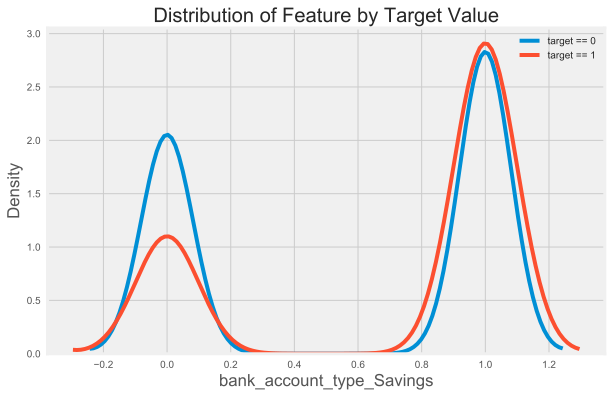

In [138]:
kde_target_plot(data, feature = 'bank_account_type_Savings')

##### collinear features

In [139]:

threshold = 0.9

correlated_pairs = {}

# Iterate through the columns
for col in correlations:
    # Find correlations above the threshold
    above_threshold_vars = [x for x in list(correlations.index[correlations[col] > threshold]) if x != col]
    correlated_pairs[col] = above_threshold_vars

In [140]:
correlated_pairs['previousloanamount_max']

['previousloanamount_mean', 'previoustotaldue_mean', 'previoustotaldue_max']

In [141]:
correlations['previousloanamount_max'].sort_values(ascending=False).head()

Variable
previousloanamount_max    1.00
previoustotaldue_max      0.99
previousloanamount_mean   0.94
previoustotaldue_mean     0.93
previoustotaldue_sum      0.90
Name: previousloanamount_max, dtype: float64

In [144]:
plt.plot(data['previousloanamount_max'], data['previoustotaldue_max'], 'bo')
plt.title('Highly Correlated Features');

##### drop correlated features

In [145]:
# Upper triangle of correlations
upper = correlations.where(np.triu(np.ones(correlations.shape), k=1).astype(np.bool))
upper.head()

TARGET  latitude_gps  loanamount  loannumber  longitude_gps  \
Variable                                                                     
TARGET            nan          0.01       -0.11       -0.08           0.01   
latitude_gps      nan           nan        0.03        0.03          -0.29   
loanamount        nan           nan         nan        0.82           0.00   
loannumber        nan           nan         nan         nan          -0.03   
longitude_gps     nan           nan         nan         nan            nan   

               systemloanid  termdays  totaldue  Client_Age  process_time  \
Variable                                                                    
TARGET                -0.02     -0.01     -0.10       -0.06          0.02   
latitude_gps          -0.01     -0.01      0.02       -0.04          0.00   
loanamount            -0.02      0.52      0.99        0.01          0.33   
loannumber            -0.01      0.34      0.80       -0.02          0.28   
longitude_gps         -0.05      0.01      0.00        0.01          0.01   

               approveddate_year  approveddate_month  approveddate_day  \
Variable                                                                 
TARGET                       nan                 nan             -0.02   
latitude_gps               -0.01               -0.01             -0.02   
loanamount                  0.02                0.02             -0.01   
loannumber                  0.01                0.01             -0.01   
longitude_gps               0.02                0.02             -0.03   

               approveddate_hour  bank_account_type_Other  \
Variable                                                    
TARGET                     -0.03                    -0.11   
latitude_gps               -0.03                     0.00   
loanamount                 -0.00                     0.28   
loannumber                 -0.01                     0.37   
longitude_gps               0.02                    -0.01   

               bank_account_type_Savings  employment_status_clients_Permanent  \
Variable                                                                        
TARGET                              0.12                                -0.02   
latitude_gps                       -0.00                                 0.03   
loanamount                         -0.27                                -0.10   
loannumber                         -0.37                                -0.13   
longitude_gps                       0.01                                 0.02   

               employment_status_clients_Retired  \
Variable                                           
TARGET                                     -0.02   
latitude_gps                               -0.02   
loanamount                                 -0.00   
loannumber                                  0.01   
longitude_gps                               0.00   

               employment_status_clients_Self-Employed  \
Variable                                                 
TARGET                                           -0.04   
latitude_gps                                     -0.03   
loanamount                                        0.21   
loannumber                                        0.26   
longitude_gps                                    -0.00   

               employment_status_clients_Student  \
Variable                                           
TARGET                                      0.02   
latitude_gps                                0.03   
loanamount                                  0.03   
loannumber                                  0.05   
longitude_gps                              -0.04   

               employment_status_clients_Unemployed  \
Variable                                              
TARGET                                        -0.00   
latitude_gps                                  -0.02   
loanamount                                    -0.01   
l

In [146]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print('There are %d columns to remove.' % (len(to_drop)))

There are 54 columns to remove.


In [147]:
print('data shape: ', data.shape)

data shape:  (24100, 116)


In [148]:
#columns to drop
data = data.drop(columns = to_drop)
print('data shape: ', data.shape)

data shape:  (24100, 80)


### Feature Selection through Feature Importances

We will use a Gradient Boosted Model from the LightGBM library to assess feature importances. 

Since the LightGBM model does not need missing values to be imputed, we can directly fit on the training data. We will use Early Stopping to determine the optimal number of iterations and run the model twice, averaging the feature importances to try and avoid overfitting to a certain set of features.

In [156]:
data.head(3)

TARGET                        customerid  latitude_gps  loanamount  \
0    0.00  8a2a81a74ce8c05d014cfb32a0da1049          6.43   30,000.00   
1    0.00  8a2a81a74ce8c05d014cfb32a0da1049          6.43   30,000.00   
2    0.00  8a2a81a74ce8c05d014cfb32a0da1049          6.43   30,000.00   

   loannumber  longitude_gps  set_x   systemloanid  termdays  Client_Age  \
0       12.00           3.43  train 301,994,762.00     30.00       47.00   
1       12.00           3.43  train 301,994,762.00     30.00       47.00   
2       12.00           3.43  train 301,994,762.00     30.00       47.00   

   process_time  approveddate_year  approveddate_day  approveddate_hour  \
0         60.00           2,017.00             25.00               8.00   
1         60.00           2,017.00             25.00               8.00   
2         60.00           2,017.00             25.00               8.00   

   bank_account_type_Other  bank_account_type_Savings  \
0                     1.00                       0.00   
1                     1.00                       0.00   
2                     1.00                       0.00   

   employment_status_clients_Permanent  employment_status_clients_Retired  \
0                                 1.00                               0.00   
1                                 1.00                               0.00   
2                                 1.00                               0.00   

   employment_status_clients_Self-Employed  employment_status_clients_Student  \
0                                     0.00                               0.00   
1                                     0.00                               0.00   
2                                     0.00                               0.00   

   employment_status_clients_Unemployed  approveddate_weekday_Monday_x  \
0                                  0.00                           0.00   
1                                  0.00                           0.00   
2                                  0.00                           0.00   

   approveddate_weekday_Saturday_x  approveddate_weekday_Sunday_x  \
0                             0.00                           0.00   
1                             0.00                           0.00   
2                             0.00                           0.00   

   approveddate_weekday_Thursday_x  approveddate_weekday_Tuesday_x  \
0                             0.00                            1.00   
1                             0.00                            1.00   
2                             0.00                            1.00   

   approveddate_weekday_Wednesday_x  interest  set_y  previous_loan_counts  \
0                              0.00  4,500.00  train                 11.00   
1                              0.00  4,500.00  train                 11.00   
2                              0.00  4,500.00  train                 11.00   

   previousloannumber_min  previousloanamount_mean  previousloanamount_min  \
0                    1.00                18,176.00               10,000.00   
1                    1.00                18,176.00               10,000.00   
2                    1.00                18,176.00               10,000.00   

   previoustotaldue_min  previoustermdays_mean  previoustermdays_max  \
0             13,000.00                  30.00                 30.00   
1             13,000.00                  30.00                 30.00   
2             13,000.00                  30.00                 30.00   

   previoustermdays_min  previousfirst_pay_diff_mean  \
0                 30.00                       552.18   
1                 30.00                       552.18   
2                 30.00                       552.18   

   previousfirst_pay_diff_max  previousfirst_pay_diff_min  \
0                   40,669.00                  -56,946.00   
1                   40,669.00                  -56,946.00   
2                   40,669.00                  -56,946.00   

 

In [157]:
train = data[data['set_x'] == 'train']
test  = data[data['set_x'] == 'test']

In [158]:
display(train.head(3))
display(test.head(3))

TARGET                        customerid  latitude_gps  loanamount  \
0    0.00  8a2a81a74ce8c05d014cfb32a0da1049          6.43   30,000.00   
1    0.00  8a2a81a74ce8c05d014cfb32a0da1049          6.43   30,000.00   
2    0.00  8a2a81a74ce8c05d014cfb32a0da1049          6.43   30,000.00   

   loannumber  longitude_gps  set_x   systemloanid  termdays  Client_Age  \
0       12.00           3.43  train 301,994,762.00     30.00       47.00   
1       12.00           3.43  train 301,994,762.00     30.00       47.00   
2       12.00           3.43  train 301,994,762.00     30.00       47.00   

   process_time  approveddate_year  approveddate_day  approveddate_hour  \
0         60.00           2,017.00             25.00               8.00   
1         60.00           2,017.00             25.00               8.00   
2         60.00           2,017.00             25.00               8.00   

   bank_account_type_Other  bank_account_type_Savings  \
0                     1.00                       0.00   
1                     1.00                       0.00   
2                     1.00                       0.00   

   employment_status_clients_Permanent  employment_status_clients_Retired  \
0                                 1.00                               0.00   
1                                 1.00                               0.00   
2                                 1.00                               0.00   

   employment_status_clients_Self-Employed  employment_status_clients_Student  \
0                                     0.00                               0.00   
1                                     0.00                               0.00   
2                                     0.00                               0.00   

   employment_status_clients_Unemployed  approveddate_weekday_Monday_x  \
0                                  0.00                           0.00   
1                                  0.00                           0.00   
2                                  0.00                           0.00   

   approveddate_weekday_Saturday_x  approveddate_weekday_Sunday_x  \
0                             0.00                           0.00   
1                             0.00                           0.00   
2                             0.00                           0.00   

   approveddate_weekday_Thursday_x  approveddate_weekday_Tuesday_x  \
0                             0.00                            1.00   
1                             0.00                            1.00   
2                             0.00                            1.00   

   approveddate_weekday_Wednesday_x  interest  set_y  previous_loan_counts  \
0                              0.00  4,500.00  train                 11.00   
1                              0.00  4,500.00  train                 11.00   
2                              0.00  4,500.00  train                 11.00   

   previousloannumber_min  previousloanamount_mean  previousloanamount_min  \
0                    1.00                18,176.00               10,000.00   
1                    1.00                18,176.00               10,000.00   
2                    1.00                18,176.00               10,000.00   

   previoustotaldue_min  previoustermdays_mean  previoustermdays_max  \
0             13,000.00                  30.00                 30.00   
1             13,000.00                  30.00                 30.00   
2             13,000.00                  30.00                 30.00   

   previoustermdays_min  previousfirst_pay_diff_mean  \
0                 30.00                       552.18   
1                 30.00                       552.18   
2                 30.00                       552.18   

   previousfirst_pay_diff_max  previousfirst_pay_diff_min  \
0                   40,669.00                  -56,946.00   
1                   40,669.00                  -56,946.00   
2                   40,669.00                  -56,946.00   

 

TARGET                        customerid  latitude_gps  loanamount  \
13678     nan  8a858f305c8dd672015c93b1db645db4          7.59   10,000.00   
13679     nan  8a858f085a477386015a47fb049e49ca          6.60   10,000.00   
13680     nan  8a858f085a477386015a47fb049e49ca          6.60   10,000.00   

       loannumber  longitude_gps set_x   systemloanid  termdays  Client_Age  \
13678        2.00           5.30  test 301,992,953.00     15.00       42.00   
13679        4.00           3.29  test            nan     29.22       40.00   
13680        4.00           3.29  test            nan     29.22       40.00   

       process_time  approveddate_year  approveddate_day  approveddate_hour  \
13678          0.00           1,900.00              1.00               0.00   
13679          0.00                nan               nan                nan   
13680          0.00                nan               nan                nan   

       bank_account_type_Other  bank_account_type_Savings  \
13678                     0.00                       1.00   
13679                     0.00                       1.00   
13680                     0.00                       1.00   

       employment_status_clients_Permanent  employment_status_clients_Retired  \
13678                                 1.00                               0.00   
13679                                 1.00                               0.00   
13680                                 1.00                               0.00   

       employment_status_clients_Self-Employed  \
13678                                     0.00   
13679                                     0.00   
13680                                     0.00   

       employment_status_clients_Student  \
13678                               0.00   
13679                               0.00   
13680                               0.00   

       employment_status_clients_Unemployed  approveddate_weekday_Monday_x  \
13678                                  0.00                           1.00   
13679                                  0.00                           0.00   
13680                                  0.00                           0.00   

       approveddate_weekday_Saturday_x  approveddate_weekday_Sunday_x  \
13678                             0.00                           0.00   
13679                             0.00                           0.00   
13680                             0.00                           0.00   

       approveddate_weekday_Thursday_x  approveddate_weekday_Tuesday_x  \
13678                             0.00                            0.00   
13679                             0.00                            0.00   
13680                             0.00                            0.00   

       approveddate_weekday_Wednesday_x  interest  set_y  \
13678                              0.00  1,500.00   test   
13679                              0.00  3,000.00  train   
13680                              0.00  3,000.00  train   

       previous_loan_counts  previousloannumber_min  previousloanamount_mean  \
13678                  1.00                    1.00                10,000.00   
13679                  4.00                    1.00                10,000.00   
13680                  4.00                    1.00                10,000.00   

       previousloanamount_min  previoustotaldue_min  previoustermdays_mean  \
13678               10,000.00             13,000.00                  30.00   
13679               10,000.00             11,500.00                  18.75   
13680               10,000.00             11,500.00                  18.75   

       previoustermdays_max  previoustermdays_min  \
13678                 30.00                 30.00   
13679                 30.00                 15.00   
13680                 30.00                 15.00   

       previousfirst_pay_diff_mean  previousfirst_pay_diff_max  \
13678                       406.00                      406

In [159]:
cols = [col for col in train if col !='TARGET'] + ['TARGET']
train = train[cols]
train.head(3)

customerid  latitude_gps  loanamount  loannumber  \
0  8a2a81a74ce8c05d014cfb32a0da1049          6.43   30,000.00       12.00   
1  8a2a81a74ce8c05d014cfb32a0da1049          6.43   30,000.00       12.00   
2  8a2a81a74ce8c05d014cfb32a0da1049          6.43   30,000.00       12.00   

   longitude_gps  set_x   systemloanid  termdays  Client_Age  process_time  \
0           3.43  train 301,994,762.00     30.00       47.00         60.00   
1           3.43  train 301,994,762.00     30.00       47.00         60.00   
2           3.43  train 301,994,762.00     30.00       47.00         60.00   

   approveddate_year  approveddate_day  approveddate_hour  \
0           2,017.00             25.00               8.00   
1           2,017.00             25.00               8.00   
2           2,017.00             25.00               8.00   

   bank_account_type_Other  bank_account_type_Savings  \
0                     1.00                       0.00   
1                     1.00                       0.00   
2                     1.00                       0.00   

   employment_status_clients_Permanent  employment_status_clients_Retired  \
0                                 1.00                               0.00   
1                                 1.00                               0.00   
2                                 1.00                               0.00   

   employment_status_clients_Self-Employed  employment_status_clients_Student  \
0                                     0.00                               0.00   
1                                     0.00                               0.00   
2                                     0.00                               0.00   

   employment_status_clients_Unemployed  approveddate_weekday_Monday_x  \
0                                  0.00                           0.00   
1                                  0.00                           0.00   
2                                  0.00                           0.00   

   approveddate_weekday_Saturday_x  approveddate_weekday_Sunday_x  \
0                             0.00                           0.00   
1                             0.00                           0.00   
2                             0.00                           0.00   

   approveddate_weekday_Thursday_x  approveddate_weekday_Tuesday_x  \
0                             0.00                            1.00   
1                             0.00                            1.00   
2                             0.00                            1.00   

   approveddate_weekday_Wednesday_x  interest  set_y  previous_loan_counts  \
0                              0.00  4,500.00  train                 11.00   
1                              0.00  4,500.00  train                 11.00   
2                              0.00  4,500.00  train                 11.00   

   previousloannumber_min  previousloanamount_mean  previousloanamount_min  \
0                    1.00                18,176.00               10,000.00   
1                    1.00                18,176.00               10,000.00   
2                    1.00                18,176.00               10,000.00   

   previoustotaldue_min  previoustermdays_mean  previoustermdays_max  \
0             13,000.00                  30.00                 30.00   
1             13,000.00                  30.00                 30.00   
2             13,000.00                  30.00                 30.00   

   previoustermdays_min  previousfirst_pay_diff_mean  \
0                 30.00                       552.18   
1                 30.00                       552.18   
2                 30.00                       552.18   

   previousfirst_pay_diff_max  previousfirst_pay_diff_min  \
0                   40,669.00                  -56,946.00   
1                   40,669.00                  -56,946.00   
2                   40,669.00                  -56,946.00   

   previousfirst_pay_diff_sum  previousrepay_day_mean  

In [160]:
cols = [col for col in test if col !='TARGET'] + ['TARGET']
test = test[cols]
test.head(3)

customerid  latitude_gps  loanamount  loannumber  \
13678  8a858f305c8dd672015c93b1db645db4          7.59   10,000.00        2.00   
13679  8a858f085a477386015a47fb049e49ca          6.60   10,000.00        4.00   
13680  8a858f085a477386015a47fb049e49ca          6.60   10,000.00        4.00   

       longitude_gps set_x   systemloanid  termdays  Client_Age  process_time  \
13678           5.30  test 301,992,953.00     15.00       42.00          0.00   
13679           3.29  test            nan     29.22       40.00          0.00   
13680           3.29  test            nan     29.22       40.00          0.00   

       approveddate_year  approveddate_day  approveddate_hour  \
13678           1,900.00              1.00               0.00   
13679                nan               nan                nan   
13680                nan               nan                nan   

       bank_account_type_Other  bank_account_type_Savings  \
13678                     0.00                       1.00   
13679                     0.00                       1.00   
13680                     0.00                       1.00   

       employment_status_clients_Permanent  employment_status_clients_Retired  \
13678                                 1.00                               0.00   
13679                                 1.00                               0.00   
13680                                 1.00                               0.00   

       employment_status_clients_Self-Employed  \
13678                                     0.00   
13679                                     0.00   
13680                                     0.00   

       employment_status_clients_Student  \
13678                               0.00   
13679                               0.00   
13680                               0.00   

       employment_status_clients_Unemployed  approveddate_weekday_Monday_x  \
13678                                  0.00                           1.00   
13679                                  0.00                           0.00   
13680                                  0.00                           0.00   

       approveddate_weekday_Saturday_x  approveddate_weekday_Sunday_x  \
13678                             0.00                           0.00   
13679                             0.00                           0.00   
13680                             0.00                           0.00   

       approveddate_weekday_Thursday_x  approveddate_weekday_Tuesday_x  \
13678                             0.00                            0.00   
13679                             0.00                            0.00   
13680                             0.00                            0.00   

       approveddate_weekday_Wednesday_x  interest  set_y  \
13678                              0.00  1,500.00   test   
13679                              0.00  3,000.00  train   
13680                              0.00  3,000.00  train   

       previous_loan_counts  previousloannumber_min  previousloanamount_mean  \
13678                  1.00                    1.00                10,000.00   
13679                  4.00                    1.00                10,000.00   
13680                  4.00                    1.00                10,000.00   

       previousloanamount_min  previoustotaldue_min  previoustermdays_mean  \
13678               10,000.00             13,000.00                  30.00   
13679               10,000.00             11,500.00                  18.75   
13680               10,000.00             11,500.00                  18.75   

       previoustermdays_max  previoustermdays_min  \
13678                 30.00                 30.00   
13679                 30.00                 15.00   
13680                 30.00                 15.00   

       previousfirst_pay_diff_mean  previousfirst_pay_diff_max  \
13678                       406.00                      406.00   
13679                    -8,704.00             

In [161]:
#drop traget column in test
test.drop('TARGET', axis=1, inplace=True)

##### drop systemloanid and set

In [162]:
train_labels = train['TARGET']
train_ids = train['customerid']
test_ids = test['customerid']

In [163]:
#remove the surveyid
columns = ['set_x','set_y', 'customerid']
test.drop(columns, inplace=True, axis=1)
train.drop(columns, inplace=True, axis=1)

In [164]:
print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (13678, 149)
Testing shape:  (6120, 148)


**<font color="red">We align the dataframes by the columns. This ensures we have the same columns in the training and testing datasets.**

In [165]:
#Match the columns in the dataframes
train, test = train.align(test, join = 'inner', axis = 1)
print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (13678, 1588)
Testing shape:  (6120, 1588)


In [166]:
display(train.head(3))
display(test.head(3))

Client_Age  approveddate_day  approveddate_hour  \
0       47.00             25.00               8.00   
1       47.00             25.00               8.00   
2       47.00             25.00               8.00   

   approveddate_weekday_Monday_x  approveddate_weekday_Monday_y  \
0                           0.00                           1.00   
1                           0.00                           0.00   
2                           0.00                           0.00   

   approveddate_weekday_Monday_y  approveddate_weekday_Monday_y  \
0                           1.00                           1.00   
1                           0.00                           0.00   
2                           0.00                           0.00   

   approveddate_weekday_Monday_y  approveddate_weekday_Monday_y  \
0                           1.00                           1.00   
1                           0.00                           0.00   
2                           0.00                           0.00   

   approveddate_weekday_Monday_y  approveddate_weekday_Monday_y  \
0                           1.00                           1.00   
1                           0.00                           0.00   
2                           0.00                           0.00   

   approveddate_weekday_Monday_y  approveddate_weekday_Monday_y  \
0                           1.00                           1.00   
1                           0.00                           0.00   
2                           0.00                           0.00   

   approveddate_weekday_Monday_y  approveddate_weekday_Monday_y  \
0                           1.00                           1.00   
1                           0.00                           0.00   
2                           0.00                           0.00   

   approveddate_weekday_Monday_y  approveddate_weekday_Monday_y  \
0                           1.00                           1.00   
1                           0.00                           0.00   
2                           0.00                           0.00   

   approveddate_weekday_Monday_y  approveddate_weekday_Monday_y  \
0                           1.00                           1.00   
1                           0.00                           0.00   
2                           0.00                           0.00   

   approveddate_weekday_Monday_y  approveddate_weekday_Monday_y  \
0                           1.00                           1.00   
1                           0.00                           0.00   
2                           0.00                           0.00   

   approveddate_weekday_Monday_y  approveddate_weekday_Monday_y  \
0                           1.00                           1.00   
1                           0.00                           0.00   
2                           0.00                           0.00   

   approveddate_weekday_Monday_y  approveddate_weekday_Monday_y  \
0                           1.00                           1.00   
1                           0.00                           0.00   
2                           0.00                           0.00   

   approveddate_weekday_Monday_y  approveddate_weekday_Monday_y  \
0                           1.00                           1.00   
1                           0.00                           0.00   
2                           0.00                           0.00   

   approveddate_weekday_Monday_y  approveddate_weekday_Monday_y  \
0                           1.00                           1.00   
1                           0.00                           0.00   
2                           0.00                           0.00   

   approveddate_weekday_Monday_y  approveddate_weekday_Monday_y  \
0                           1.00                           1.00   
1                           0.00                           0.00   
2                           0.00                           0.00   

   approveddate_week

Client_Age  approveddate_day  approveddate_hour  \
13678       42.00              1.00               0.00   
13679       40.00               nan                nan   
13680       40.00               nan                nan   

       approveddate_weekday_Monday_x  approveddate_weekday_Monday_y  \
13678                           1.00                           0.00   
13679                           0.00                           1.00   
13680                           0.00                           0.00   

       approveddate_weekday_Monday_y  approveddate_weekday_Monday_y  \
13678                           0.00                           0.00   
13679                           1.00                           1.00   
13680                           0.00                           0.00   

       approveddate_weekday_Monday_y  approveddate_weekday_Monday_y  \
13678                           0.00                           0.00   
13679                           1.00                           1.00   
13680                           0.00                           0.00   

       approveddate_weekday_Monday_y  approveddate_weekday_Monday_y  \
13678                           0.00                           0.00   
13679                           1.00                           1.00   
13680                           0.00                           0.00   

       approveddate_weekday_Monday_y  approveddate_weekday_Monday_y  \
13678                           0.00                           0.00   
13679                           1.00                           1.00   
13680                           0.00                           0.00   

       approveddate_weekday_Monday_y  approveddate_weekday_Monday_y  \
13678                           0.00                           0.00   
13679                           1.00                           1.00   
13680                           0.00                           0.00   

       approveddate_weekday_Monday_y  approveddate_weekday_Monday_y  \
13678                           0.00                           0.00   
13679                           1.00                           1.00   
13680                           0.00                           0.00   

       approveddate_weekday_Monday_y  approveddate_weekday_Monday_y  \
13678                           0.00                           0.00   
13679                           1.00                           1.00   
13680                           0.00                           0.00   

       approveddate_weekday_Monday_y  approveddate_weekday_Monday_y  \
13678                           0.00                           0.00   
13679                           1.00                           1.00   
13680                           0.00                           0.00   

       approveddate_weekday_Monday_y  approveddate_weekday_Monday_y  \
13678                           0.00                           0.00   
13679                           1.00                           1.00   
13680                           0.00                           0.00   

       approveddate_weekday_Monday_y  approveddate_weekday_Monday_y  \
13678                           0.00                           0.00   
13679                           1.00                           1.00   
13680                           0.00                           0.00   

       approveddate_weekday_Monday_y  approveddate_weekday_Monday_y  \
13678                           0.00                           0.00   
13679                           1.00                           1.00   
13680                           0.00                           0.00   

       approveddate_weekday_Monday_y  approveddate_weekday_Monday_y  \
13678                           0.00                           0.00   
13679                           1.00                           1.00   
13680                           0.00                           0.00   

       approveddate_weekday_Monday_y  approveddate_weekday_Monday_y  

#### Feature Importance

In [167]:
# modeling 
import lightgbm as lgb

# utilities
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

In [168]:
# Initialize an empty array to hold feature importances
feature_importances = np.zeros(train.shape[1])

# Create the model with several hyperparameters
model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')

In [169]:
# Fit the model twice to avoid overfitting
for i in range(2):
    
    # Split into training and validation set
    train_features, valid_features, train_y, valid_y = train_test_split(train, train_labels, test_size = 0.25, random_state = i)
    
    # Train using early stopping
    model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
              eval_metric = 'auc', verbose = 200)
    
    # Record the feature importances
    feature_importances += model.feature_importances_

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.988491
[400]	valid_0's auc: 0.989383
Early stopping, best iteration is:
[348]	valid_0's auc: 0.989902
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.993426
Early stopping, best iteration is:
[236]	valid_0's auc: 0.99384


In [171]:
# Make sure to average feature importances! 
x = feature_importances / 2
feature_importances = pd.DataFrame({'feature': list(train.columns), 
                                    'importance': feature_importances}).sort_values('importance', ascending = False)

feature_importances.head()

TypeError: Could not operate 2 with block values unsupported operand type(s) for /: 'str' and 'int'

In [172]:
# Find the features with zero importance
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
feature_importances.tail()

There are 1534 features with 0.0 importance


feature  importance
555    approveddate_weekday_Sunday_y        0.00
554    approveddate_weekday_Sunday_y        0.00
553    approveddate_weekday_Sunday_y        0.00
552    approveddate_weekday_Sunday_y        0.00
794  approveddate_weekday_Thursday_y        0.00

It looks like many of the features we made have literally 0 importance. For the gradient boosting machine, features with 0 importance are not used at all to make any splits. Therefore, we can remove these features from the model with no effect on performance.

In [173]:
def plot_feature_importances(df, threshold = 0.9):
    
    plt.rcParams['font.size'] = 14
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (10, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

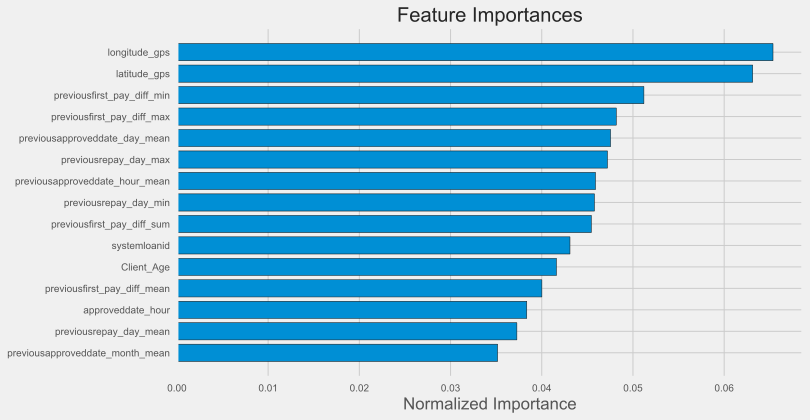

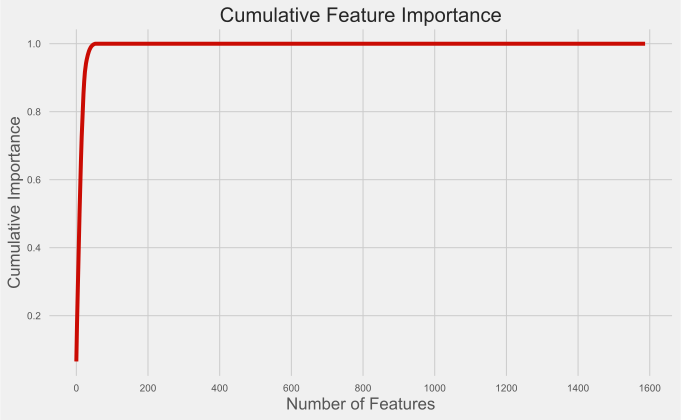

24 features required for 0.90 of cumulative importance


In [174]:
norm_feature_importances = plot_feature_importances(feature_importances)

Let's remove the features that have zero importance.

In [175]:
train = train.drop(columns = zero_features)
test = test.drop(columns = zero_features)

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (13678, 48)
Testing shape:  (6120, 48)


At this point, we can re-run the model to see if it identifies any more features with zero importance. In a way, we are implementing our own form of recursive feature elimination. 

In [176]:
def identify_zero_importance_features(train, train_labels, iterations = 2):

    # Initialize an empty array to hold feature importances
    feature_importances = np.zeros(train.shape[1])

    # Create the model with several hyperparameters
    model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000,class_weight = 'balanced')
    
    # Fit the model multiple times to avoid overfitting
    for i in range(iterations):
        
        # Split into training and validation set
        train_features, valid_features, train_y, valid_y = train_test_split(train, train_labels, test_size = 0.25, random_state = i)

        # Train using early stopping
        model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
                  eval_metric = 'auc', verbose = 200)

        # Record the feature importances
        feature_importances += model.feature_importances_ / iterations
    
    feature_importances = pd.DataFrame({'feature': list(train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)
    
    # Find the features with zero importance
    zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
    print('\nThere are %d features with 0.0 importance' % len(zero_features))
    
    return zero_features, feature_importances

In [177]:
second_round_zero_features, feature_importances = identify_zero_importance_features(train, train_labels)

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.988468
[400]	valid_0's auc: 0.989729
Early stopping, best iteration is:
[395]	valid_0's auc: 0.989855
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.99319
Early stopping, best iteration is:
[264]	valid_0's auc: 0.994351

There are 0 features with 0.0 importance


Now, there are no 0 importance features left. If we want to remove more features, we will create a threshold percentage of importance, such as 95%, to remove less important features.

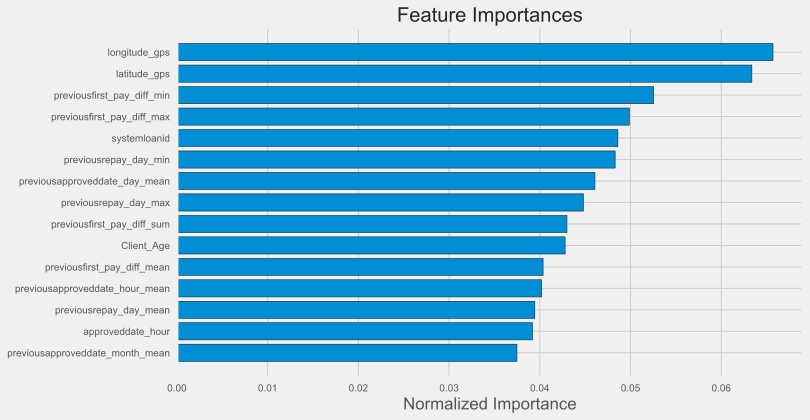

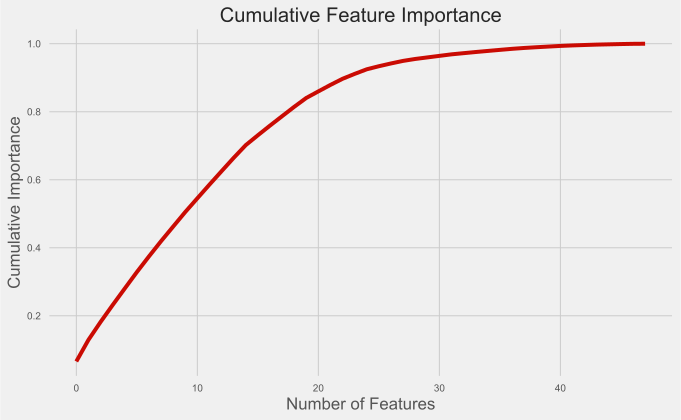

29 features required for 0.95 of cumulative importance


In [178]:
norm_feature_importances = plot_feature_importances(feature_importances, threshold = 0.95)

We can keep only the features needed for 95% importance. 

Then, we can test both versions of the data to see if the extra feature removal step is worthwhile.

In [179]:
# Threshold for cumulative importance
threshold = 0.95

# Extract the features to keep
features_to_keep = list(norm_feature_importances[norm_feature_importances['cumulative_importance'] < threshold]['feature'])

# Create new datasets with smaller features
train_small = train[features_to_keep]
test_small = test[features_to_keep]

In [180]:
train_small['TARGET'] = train_labels
train_small['surveyid'] = train_ids
test_small['surveyid'] = test_ids

train_small.to_csv('../data/interim/m_train_small.csv', index = False)
test_small.to_csv('../data/interim/m_test_small.csv', index = False)

### Test New Featuresets

Since, the last step of feature removal seems like it may potentially hurt the model the most. Therefore, we want to test the effect of this removal. To do that, we can use a standard model and change the features.

We will also use LightGBM model with two different datasets to see which one perform better.

In [181]:
def model(features, test_features, encoding = 'ohe', n_folds = 5):
    
    """Train and test a light gradient boosting model using
    cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation
        
    Return
    --------
        submission (pd.DataFrame): 
            dataframe with `surveyid` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
    # Extract the ids
    train_ids = features['customerid']
    test_ids = test_features['customerid']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['customerid', 'TARGET'])
    test_features = test_features.drop(columns = ['customerid'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = False, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', boosting_type='goss',
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'customerid': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

### Test "Full" Dataset

This is the expanded dataset. To recap the process to make this dataset we:

1. Removed collinear features as measured by the correlation coefficient greater than 0.9
2. Removed any columns with greater than 75% missing values in the train or test set
3. Removed all features with non-zero feature importances

In [182]:
test.head(3)

Client_Age  approveddate_day  approveddate_hour  \
13678       42.00              1.00               0.00   
13679       40.00               nan                nan   
13680       40.00               nan                nan   

       approveddate_weekday_Monday_x  approveddate_weekday_Saturday_x  \
13678                           1.00                             0.00   
13679                           0.00                             0.00   
13680                           0.00                             0.00   

       approveddate_weekday_Sunday_x  approveddate_weekday_Thursday_x  \
13678                           0.00                             0.00   
13679                           0.00                             0.00   
13680                           0.00                             0.00   

       approveddate_weekday_Tuesday_x  approveddate_weekday_Wednesday_x  \
13678                            0.00                              0.00   
13679                            0.00                              0.00   
13680                            0.00                              0.00   

       bank_account_type_Other  bank_account_type_Savings  \
13678                     0.00                       1.00   
13679                     0.00                       1.00   
13680                     0.00                       1.00   

       employment_status_clients_Permanent  \
13678                                 1.00   
13679                                 1.00   
13680                                 1.00   

       employment_status_clients_Self-Employed  \
13678                                     0.00   
13679                                     0.00   
13680                                     0.00   

       employment_status_clients_Student  \
13678                               0.00   
13679                               0.00   
13680                               0.00   

       employment_status_clients_Unemployed  interest  latitude_gps  \
13678                                  0.00  1,500.00          7.59   
13679                                  0.00  3,000.00          6.60   
13680                                  0.00  3,000.00          6.60   

       loanamount  loannumber  longitude_gps  previous_loan_counts  \
13678   10,000.00        2.00           5.30                  1.00   
13679   10,000.00        4.00           3.29                  4.00   
13680   10,000.00        4.00           3.29                  4.00   

       previousapproveddate_day_max  previousapproveddate_day_mean  \
13678                         11.00                          11.00   
13679                         20.00                          13.50   
13680                         20.00                          13.50   

       previousapproveddate_day_min  previousapproveddate_hour_max  \
13678                         11.00                          13.00   
13679                          5.00                          15.00   
13680                          5.00                          15.00   

       previousapproveddate_hour_mean  previousapproveddate_hour_min  \
13678                           13.00                          13.00   
13679                            9.00                           6.00   
13680                            9.00                           6.00   

       previousapproveddate_month_max  previousapproveddate_month_mean  \
13678                            6.00                             6.00   
13679                            6.00                             3.75   
13680                            6.00                             3.75   

       previousapproveddate_month_min  previousapproveddate_year_max  \
13678                            6.00                       2,017.00   
13679                            2.00                       2,017.00   
13680                            2.00                       2,017.00   

       previousapproveddate_year_mean  previousfirst_pay_diff_max  \
13678  

In [183]:
train = data[data['set_x'] == 'train']
test  = data[data['set_x'] == 'test']

In [184]:
cols = [col for col in train if col !='TARGET'] + ['TARGET']
train = train[cols]

In [185]:
cols = [col for col in test if col !='TARGET'] + ['TARGET']
test = test[cols]

In [186]:
display(train.head(3))
display(test.head(3))

customerid  latitude_gps  loanamount  loannumber  \
0  8a2a81a74ce8c05d014cfb32a0da1049          6.43   30,000.00       12.00   
1  8a2a81a74ce8c05d014cfb32a0da1049          6.43   30,000.00       12.00   
2  8a2a81a74ce8c05d014cfb32a0da1049          6.43   30,000.00       12.00   

   longitude_gps  set_x   systemloanid  termdays  Client_Age  process_time  \
0           3.43  train 301,994,762.00     30.00       47.00         60.00   
1           3.43  train 301,994,762.00     30.00       47.00         60.00   
2           3.43  train 301,994,762.00     30.00       47.00         60.00   

   approveddate_year  approveddate_day  approveddate_hour  \
0           2,017.00             25.00               8.00   
1           2,017.00             25.00               8.00   
2           2,017.00             25.00               8.00   

   bank_account_type_Other  bank_account_type_Savings  \
0                     1.00                       0.00   
1                     1.00                       0.00   
2                     1.00                       0.00   

   employment_status_clients_Permanent  employment_status_clients_Retired  \
0                                 1.00                               0.00   
1                                 1.00                               0.00   
2                                 1.00                               0.00   

   employment_status_clients_Self-Employed  employment_status_clients_Student  \
0                                     0.00                               0.00   
1                                     0.00                               0.00   
2                                     0.00                               0.00   

   employment_status_clients_Unemployed  approveddate_weekday_Monday_x  \
0                                  0.00                           0.00   
1                                  0.00                           0.00   
2                                  0.00                           0.00   

   approveddate_weekday_Saturday_x  approveddate_weekday_Sunday_x  \
0                             0.00                           0.00   
1                             0.00                           0.00   
2                             0.00                           0.00   

   approveddate_weekday_Thursday_x  approveddate_weekday_Tuesday_x  \
0                             0.00                            1.00   
1                             0.00                            1.00   
2                             0.00                            1.00   

   approveddate_weekday_Wednesday_x  interest  set_y  previous_loan_counts  \
0                              0.00  4,500.00  train                 11.00   
1                              0.00  4,500.00  train                 11.00   
2                              0.00  4,500.00  train                 11.00   

   previousloannumber_min  previousloanamount_mean  previousloanamount_min  \
0                    1.00                18,176.00               10,000.00   
1                    1.00                18,176.00               10,000.00   
2                    1.00                18,176.00               10,000.00   

   previoustotaldue_min  previoustermdays_mean  previoustermdays_max  \
0             13,000.00                  30.00                 30.00   
1             13,000.00                  30.00                 30.00   
2             13,000.00                  30.00                 30.00   

   previoustermdays_min  previousfirst_pay_diff_mean  \
0                 30.00                       552.18   
1                 30.00                       552.18   
2                 30.00                       552.18   

   previousfirst_pay_diff_max  previousfirst_pay_diff_min  \
0                   40,669.00                  -56,946.00   
1                   40,669.00                  -56,946.00   
2                   40,669.00                  -56,946.00   

   previousfirst_pay_diff_sum  previousrepay_day_mean  

customerid  latitude_gps  loanamount  loannumber  \
13678  8a858f305c8dd672015c93b1db645db4          7.59   10,000.00        2.00   
13679  8a858f085a477386015a47fb049e49ca          6.60   10,000.00        4.00   
13680  8a858f085a477386015a47fb049e49ca          6.60   10,000.00        4.00   

       longitude_gps set_x   systemloanid  termdays  Client_Age  process_time  \
13678           5.30  test 301,992,953.00     15.00       42.00          0.00   
13679           3.29  test            nan     29.22       40.00          0.00   
13680           3.29  test            nan     29.22       40.00          0.00   

       approveddate_year  approveddate_day  approveddate_hour  \
13678           1,900.00              1.00               0.00   
13679                nan               nan                nan   
13680                nan               nan                nan   

       bank_account_type_Other  bank_account_type_Savings  \
13678                     0.00                       1.00   
13679                     0.00                       1.00   
13680                     0.00                       1.00   

       employment_status_clients_Permanent  employment_status_clients_Retired  \
13678                                 1.00                               0.00   
13679                                 1.00                               0.00   
13680                                 1.00                               0.00   

       employment_status_clients_Self-Employed  \
13678                                     0.00   
13679                                     0.00   
13680                                     0.00   

       employment_status_clients_Student  \
13678                               0.00   
13679                               0.00   
13680                               0.00   

       employment_status_clients_Unemployed  approveddate_weekday_Monday_x  \
13678                                  0.00                           1.00   
13679                                  0.00                           0.00   
13680                                  0.00                           0.00   

       approveddate_weekday_Saturday_x  approveddate_weekday_Sunday_x  \
13678                             0.00                           0.00   
13679                             0.00                           0.00   
13680                             0.00                           0.00   

       approveddate_weekday_Thursday_x  approveddate_weekday_Tuesday_x  \
13678                             0.00                            0.00   
13679                             0.00                            0.00   
13680                             0.00                            0.00   

       approveddate_weekday_Wednesday_x  interest  set_y  \
13678                              0.00  1,500.00   test   
13679                              0.00  3,000.00  train   
13680                              0.00  3,000.00  train   

       previous_loan_counts  previousloannumber_min  previousloanamount_mean  \
13678                  1.00                    1.00                10,000.00   
13679                  4.00                    1.00                10,000.00   
13680                  4.00                    1.00                10,000.00   

       previousloanamount_min  previoustotaldue_min  previoustermdays_mean  \
13678               10,000.00             13,000.00                  30.00   
13679               10,000.00             11,500.00                  18.75   
13680               10,000.00             11,500.00                  18.75   

       previoustermdays_max  previoustermdays_min  \
13678                 30.00                 30.00   
13679                 30.00                 15.00   
13680                 30.00                 15.00   

       previousfirst_pay_diff_mean  previousfirst_pay_diff_max  \
13678                       406.00                      406.00   
13679                    -8,704.00             

In [187]:
print(train.shape)
print(test.shape)

(13678, 152)
(6120, 152)


In [188]:
train['TARGET'] = train_labels
train['customerid'] = train_ids
test['customerid'] = test_ids

submission, feature_importances, metrics = model(train, test)

Training Data Shape:  (13678, 1589)
Testing Data Shape:  (6120, 1589)
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.702325	train's auc: 0.99943
Early stopping, best iteration is:
[131]	valid's auc: 0.705301	train's auc: 0.997471
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[10]	valid's auc: 0.677077	train's auc: 0.918749
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[29]	valid's auc: 0.599283	train's auc: 0.959321
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[50]	valid's auc: 0.720919	train's auc: 0.979213
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[23]	valid's auc: 0.696136	train's auc: 0.95013


In [189]:
metrics

fold  train  valid
0        0   1.00   0.71
1        1   0.92   0.68
2        2   0.96   0.60
3        3   0.98   0.72
4        4   0.95   0.70
5  overall   0.96   0.67

In [190]:
submission.to_csv('selected_features_submission.csv', index = False)

The full featureset scores __0.45__ when submitted to the public leaderboard.

### Test "Small" Dataset

The small dataset requires one additional step over the ful l dataset:

* Keep only features needed to reach 95% cumulative importance in the gradient boosting machine

In [191]:
submission_small, feature_importances_small, metrics_small = model(train_small, test_small)

KeyError: 'customerid'

In [186]:
metrics_small

NameError: name 'metrics_small' is not defined

In [187]:
submission_small.to_csv('selected_features_small_submission.csv', index = False)

NameError: name 'submission_small' is not defined

The smaller featureset scores __0.37__ when submitted to the public leaderboard.

---

## MODELLING

### Fill missing values for linear models

In [248]:
features_sample.to_csv('../data/interim/model.csv', index=False)

In [249]:
data = pd.read_csv('../data/interim/model.csv')
data.head()

customerid  TARGET  latitude_gps  loanamount  \
0  8a1088a0484472eb01484669e3ce4e0b       1          6.66   10,000.00   
1  8a1a1e7e4f707f8b014f797718316cad       0          6.59   30,000.00   
2  8a1a32fc49b632520149c3b8fdf85139       0          6.65   20,000.00   
3  8a1eb5ba49a682300149c3c068b806c7       0          6.42   30,000.00   
4  8a1edbf14734127f0147356fdb1b1eb2      -1          4.80   10,000.00   

   loannumber  longitude_gps    set   systemloanid  termdays  Client_Age  \
0        2.00           3.35  train 301,999,397.00     15.00          29   
1        5.00           3.40  train 301,997,672.00     60.00          39   
2        8.00           3.31  train 301,976,551.00     30.00          39   
3        9.00           3.43  train 301,975,382.00     60.00          40   
4        4.00           6.98   test 301,979,481.50     29.22          40   

   process_time  bank_account_type_Other  bank_account_type_Savings  \
0            60                        0                          1   
1            60                        1                          0   
2            60                        0                          1   
3            60                        0                          1   
4             0                        0                          1   

   employment_status_clients_Permanent  employment_status_clients_Retired  \
0                                    1                                  0   
1                                    1                                  0   
2                                    1                                  0   
3                                    1                                  0   
4                                    1                                  0   

   employment_status_clients_Self-Employed  employment_status_clients_Student  \
0                                        0                                  0   
1                                        0                                  0   
2                                        0                                  0   
3                                        0                                  0   
4                                        0                                  0   

   employment_status_clients_Unemployed  approved_year  approveddate_day  \
0                                     0       2,017.00             27.00   
1                                     0       2,017.00             26.00   
2                                     0       2,017.00             13.00   
3                                     0       2,017.00             13.00   
4                                     0       2,017.00             13.00   

   approveddate_hour  SUM(app_prev.loannumber)  SUM(app_prev.first_pay_diff)  \
0              19.00                      1.00                     -9,881.00   
1              20.00                     10.00                     -2,240.00   
2              19.00                     28.00                     -1,279.00   
3               0.00                     36.00                     29,046.00   
4              12.00                      3.00                     10,095.00   

   STD(app_prev.loanamount)  STD(app_prev.totaldue)  STD(app_prev.termdays)  \
0                       inf                5,276.31                    6.71   
1                       inf               12,338.12                   15.00   
2                       inf                6,343.35                    7.32   
3                       inf                9,255.11                   10.61   
4                      0.00                1,060.66                   10.61   

   STD(app_prev.first_pay_diff)  STD(app_prev.repay_day)  \
0                      6,426.61                11,963.36   
1                      1,163.60                 3,613.40   
2                      1,484.30                10,056.72   
3                      8,882.16                13,617.98   
4                      7,620.49        

In [251]:
# Missing values statistics
missing_values_table(data)

Your selected dataframe has 47 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

### Separate train and test

In [252]:
train_data = data[data['set'] == 'train']
test_data  = data[data['set'] == 'test']

In [253]:
display(train.head(3))
display(test.head(3))

customerid  TARGET  latitude_gps  loanamount  \
3877  8a858fa257d8223c0157de93b03e51bb       0          6.59   30,000.00   
3562  8a858f7d5a53db95015a5a093673725a       0          6.44   20,000.00   
1888  8a858eb95b8c2f6e015b8cb299b128a0       0          6.67   20,000.00   

      loannumber  longitude_gps   systemloanid  termdays  Client_Age  \
3877        8.00           3.40 301,971,028.00     30.00          31   
3562        5.00           3.52 302,000,221.00     15.00          28   
1888        5.00           3.29 301,982,765.00     30.00          38   

      process_time  bank_account_type_Other  bank_account_type_Savings  \
3877            60                        1                          0   
3562            60                        0                          1   
1888            60                        0                          1   

      employment_status_clients_Permanent  employment_status_clients_Retired  \
3877                                    0                                  0   
3562                                    1                                  0   
1888                                    1                                  0   

      employment_status_clients_Self-Employed  \
3877                                        1   
3562                                        0   
1888                                        0   

      employment_status_clients_Student  employment_status_clients_Unemployed  \
3877                                  0                                     0   
3562                                  0                                     0   
1888                                  0                                     0   

      approved_year  approveddate_day  approveddate_hour  \
3877       2,017.00             10.00               9.00   
3562       2,017.00             28.00              10.00   
1888       2,017.00             17.00              21.00   

      SUM(app_prev.loannumber)  SUM(app_prev.first_pay_diff)  \
3877                     28.00                     -4,481.00   
3562                     10.00                     19,902.00   
1888                     10.00                     22,387.00   

      STD(app_prev.loanamount)  STD(app_prev.totaldue)  \
3877                       inf                8,608.60   
3562                       inf                3,021.41   
1888                       inf                6,041.52   

      STD(app_prev.termdays)  STD(app_prev.first_pay_diff)  \
3877                    7.32                      5,897.69   
3562                    7.50                      2,797.49   
1888                    7.50                      3,241.48   

      STD(app_prev.repay_day)  MAX(app_prev.termdays)  \
3877                16,562.63                   30.00   
3562                10,886.58                   30.00   
1888                 8,935.19                   30.00   

      MAX(app_prev.first_pay_diff)  MAX(app_prev.repay_day)  \
3877                      4,980.00                60,608.00   
3562                      8,819.00                41,645.00   
1888                      9,158.00                38,507.00   

      SKEW(app_prev.loannumber)  SKEW(app_prev.loanamount)  \
3877                       0.00                       0.00   
3562                       0.00                       0.00   
1888                       0.00                       0.00   

      SKEW(app_prev.totaldue)  SKEW(app_prev.termdays)  \
3877                     1.02                     1.23   
3562                     1.66                    -2.00   
1888                     1.92                    -2.00   

      SKEW(app_prev.first_pay_diff)  SKEW(app_prev.repay_day)  \
3877                          -1.82                      1.58   
3562                           1.08                     -1.87   
1888                           0.03                     -1.67   

      MIN(app_prev.loannumber)  MIN(app_prev.loanamount)  \
3877                      1.0

customerid  TARGET  latitude_gps  loanamount  \
4748  8a858fff5a36fe68015a37f8550a02a2       0          6.44   30,000.00   
639   8a858e165b90faf9015b9654b6e01bdd       0          6.46   10,000.00   
486   8a858e035a187786015a18af59052988       0          6.43   10,000.00   

      loannumber  longitude_gps   systemloanid  termdays  Client_Age  \
4748        7.00           3.49 301,989,105.00     30.00          31   
639         2.00           3.74 301,974,826.00     30.00          31   
486         4.00           3.43 301,984,140.00     30.00          50   

      process_time  bank_account_type_Other  bank_account_type_Savings  \
4748            60                        0                          1   
639             60                        0                          1   
486             60                        0                          1   

      employment_status_clients_Permanent  employment_status_clients_Retired  \
4748                                    1                                  0   
639                                     1                                  0   
486                                     1                                  0   

      employment_status_clients_Self-Employed  \
4748                                        0   
639                                         0   
486                                         0   

      employment_status_clients_Student  employment_status_clients_Unemployed  \
4748                                  0                                     0   
639                                   0                                     0   
486                                   0                                     0   

      approved_year  approveddate_day  approveddate_hour  \
4748       2,017.00             21.00              11.00   
639        2,017.00             12.00              15.00   
486        2,017.00             18.00              15.00   

      SUM(app_prev.loannumber)  SUM(app_prev.first_pay_diff)  \
4748                     21.00                     20,242.00   
639                       1.00                      5,992.00   
486                       6.00                     -3,526.00   

      STD(app_prev.loanamount)  STD(app_prev.totaldue)  \
4748                       inf                6,473.15   
639                        inf                5,276.31   
486                       0.00                  866.03   

      STD(app_prev.termdays)  STD(app_prev.first_pay_diff)  \
4748                    6.12                      4,595.47   
639                     6.71                      6,426.61   
486                     8.66                      4,810.22   

      STD(app_prev.repay_day)  MAX(app_prev.termdays)  \
4748                11,519.47                   30.00   
639                 11,963.36                   30.00   
486                  8,783.14                   30.00   

      MAX(app_prev.first_pay_diff)  MAX(app_prev.repay_day)  \
4748                     10,701.00                43,817.00   
639                       5,992.00                36,181.00   
486                       3,571.00                43,544.00   

      SKEW(app_prev.loannumber)  SKEW(app_prev.loanamount)  \
4748                       0.00                       0.00   
639                        0.00                       0.00   
486                        0.00                       0.00   

      SKEW(app_prev.totaldue)  SKEW(app_prev.termdays)  \
4748                    -0.02                    -2.45   
639                      0.18                     0.00   
486                     -1.73                    -1.73   

      SKEW(app_prev.first_pay_diff)  SKEW(app_prev.repay_day)  \
4748                           0.65                     -2.16   
639                            0.32                      0.17   
486                           -0.12                     -1.17   

      MIN(app_prev.loannumber)  MIN(app_prev.loanamount)  \
4748                      1.0

In [254]:
#splitting application_train_newdf into train and test
from sklearn.model_selection import train_test_split
train,test = train_test_split(train_data,test_size=.3,random_state = 123)

train = train.drop(columns="set",axis=1)
test  = test.drop(columns="set",axis=1)

#seperating dependent and independent variables
train_X = train[[i for i in train.columns if i not in ['customerid'] + [ 'TARGET']]]
train_Y = train[["TARGET"]]

test_X  = test[[i for i in test.columns if i not in ['customerid'] + [ 'TARGET']]]
test_Y  = test[["TARGET"]]

In [255]:
#get class settings
zero = train[train["TARGET"] == 0]
one = train[train["TARGET"] == 1]

print(zero.shape)
print(one.shape)

(1800, 46)
(488, 46)


### Handle class imbalance

In [256]:
# Up-sample Minority Class
from sklearn.utils import resample

#separating majority and minority classes
df_majority = train[train["TARGET"] == 0]
df_minority = train[train["TARGET"] == 1]

#upsample minority data
df_minority_upsampled = resample(df_minority,
                                 replace=True,
                                 n_samples =1784,
                                 random_state=123)

df_upsampled = pd.concat([df_majority,df_minority_upsampled],axis=0)

#splitting dependent and independent variables
df_upsampled_X = df_upsampled[[i for i in df_upsampled.columns if i not in ['customerid'] + [ 'TARGET']]]
df_upsampled_Y = df_upsampled[["TARGET"]]

In [257]:
# Down-sample Majority Class
from sklearn.utils import resample

#separating majority and minority classes
df_majority = train[train["TARGET"] == 0]
df_minority = train[train["TARGET"] == 1]

df_majority_downsampled = resample(df_majority,
                                   replace=False,
                                   n_samples=498,
                                   random_state=123)

df_downsampled = pd.concat([df_minority,df_majority_downsampled],axis=0)

#splitting dependent and independent variables

df_downsampled_X = df_downsampled[[i for i in df_downsampled.columns if i not in ['customerid'] + [ 'TARGET']]]
df_downsampled_Y = df_downsampled[["TARGET"]]

### Function to measure the model

In [258]:
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,roc_auc_score,classification_report,roc_auc_score,roc_curve,auc

#Model function
def model(algorithm,dtrain_X,dtrain_Y,dtest_X,dtest_Y,cols=None):

    algorithm.fit(dtrain_X[cols],dtrain_Y)
    predictions = algorithm.predict(dtest_X[cols])
    print (algorithm)
    
    print ("Accuracy score : ", accuracy_score(predictions,dtest_Y))
    print ("Recall score   : ", recall_score(predictions,dtest_Y))
    print ("classification report :\n",classification_report(predictions,dtest_Y))
    
    fig = plt.figure(figsize=(10,8))
    ax  = fig.add_subplot(111)
    prediction_probabilities = algorithm.predict_proba(dtest_X[cols])[:,1]
    fpr , tpr , thresholds   = roc_curve(dtest_Y,prediction_probabilities)
    ax.plot(fpr,tpr,label   = ["Area under curve : ",auc(fpr,tpr)],linewidth=2,linestyle="dotted")
    ax.plot([0,1],[0,1],linewidth=2,linestyle="dashed")
    plt.legend(loc="best")
    plt.title("ROC-CURVE & AREA UNDER CURVE")
    #ax.set_facecolor("k")


#### LogisticRegression

In [259]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression()
model(logit,df_downsampled_X,df_downsampled_Y,test_X,test_Y,df_downsampled_X.columns)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

#### Random Forest Classifier

In [202]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
model(rfc,df_downsampled_X,df_downsampled_Y,test_X,test_Y,df_downsampled_X.columns)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

#### Decision Tree Classifier

In [203]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
model(dtc,df_downsampled_X,df_downsampled_Y,test_X,test_Y,df_downsampled_X.columns)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

#### Gaussian Naive Bayes

In [204]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
model(gnb,df_downsampled_X,df_downsampled_Y,test_X,test_Y,df_downsampled_X.columns)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

#### XGBoost Classifier

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
Accuracy score :  0.6493374108053007
Recall score   :  0.34704370179948585
classification report :
              precision    recall  f1-score   support

          0       0.66      0.85      0.74       592
          1       0.60      0.35      0.44       389

avg / total       0.64      0.65      0.62       981



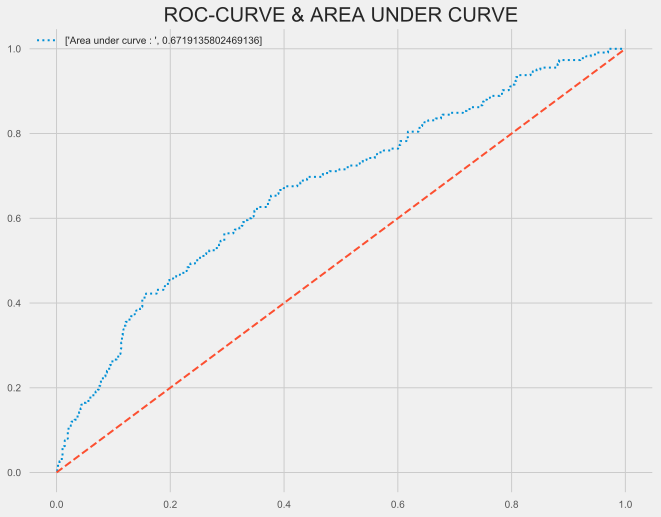

In [205]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
model(xgb,df_downsampled_X,df_downsampled_Y,test_X,test_Y,df_downsampled_X.columns)

#### Gradient Boosting Classifier

In [206]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
model(gbc,df_downsampled_X,df_downsampled_Y,test_X,test_Y,df_downsampled_X.columns)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

**<font color="red">Best model is XGBboost with an accuracy of 0.67**

In [207]:
test_data.head()

customerid  TARGET  latitude_gps  loanamount  \
4   8a1edbf14734127f0147356fdb1b1eb2      -1          4.80   10,000.00   
7   8a2ac4745091002b0150a144bcbe58b7      -1         11.98   10,000.00   
11  8a390a2150ad97330150aebdd8ef7456      -1          4.82   10,000.00   
12  8a399f284741b63b0147496a04db1eb4      -1          6.63   10,000.00   
13  8a5cfa8345d40fb80145dc328532397a      -1          6.57   10,000.00   

    loannumber  longitude_gps   set   systemloanid  termdays  Client_Age  \
4         4.00           6.98  test 301,979,481.50     29.22          40   
7         4.00           8.57  test 301,979,481.50     29.22          32   
11        4.00           7.04  test 301,979,481.50     29.22          30   
12        4.00           3.34  test 301,979,481.50     29.22          44   
13        4.00           3.35  test 301,979,481.50     29.22          47   

    process_time  bank_account_type_Other  bank_account_type_Savings  \
4              0                        0                          1   
7              0                        1                          0   
11             0                        0                          1   
12             0                        0                          1   
13             0                        1                          0   

    employment_status_clients_Permanent  employment_status_clients_Retired  \
4                                     1                                  0   
7                                     1                                  0   
11                                    1                                  0   
12                                    1                                  0   
13                                    1                                  0   

    employment_status_clients_Self-Employed  \
4                                         0   
7                                         0   
11                                        0   
12                                        0   
13                                        0   

    employment_status_clients_Student  employment_status_clients_Unemployed  \
4                                   0                                     0   
7                                   0                                     0   
11                                  0                                     0   
12                                  0                                     0   
13                                  0                                     0   

    approved_year  approveddate_day  approveddate_hour  \
4        2,017.00             13.00              12.00   
7        2,017.00             13.00              12.00   
11       2,017.00             13.00              12.00   
12       2,017.00             13.00              12.00   
13       2,017.00             13.00              12.00   

    SUM(app_prev.loannumber)  SUM(app_prev.first_pay_diff)  \
4                       3.00                     10,095.00   
7                      28.00                     20,784.00   
11                     36.00                     -1,876.00   
12                      3.00                    -28,603.00   
13                      0.00                          0.00   

    STD(app_prev.loanamount)  STD(app_prev.totaldue)  STD(app_prev.termdays)  \
4                       0.00                1,060.66                   10.61   
7                        inf               13,176.60                   16.04   
11                       inf                9,883.30                    6.94   
12                       inf                5,276.31                    6.71   
13                       inf                5,276.31                    6.71   

    STD(app_prev.first_pay_diff)  STD(app_prev.repay_day)  \
4                       7,620.49                 7,475.53   
7                       3,386.87                21,268.69   
11                      1,355.47                 9,709.15   
12               

In [208]:
#drop traget column in test
columns = ['TARGET','set']
test_data.drop(columns, axis=1, inplace=True)

In [209]:
test_sub_X = test_data[[i for i in df_downsampled.columns if i not in ['customerid'] + [ 'TARGET']]]
xgb = XGBClassifier()
xgb.fit(df_downsampled_X,df_downsampled_Y)
sub_prob = xgb.predict_proba(test_sub_X)[:,1]
sub_prob = pd.DataFrame(sub_prob)
ids = test_data[["customerid"]]
subm  = ids.merge(sub_prob,left_index=True,right_index=True,how="left")
sample_submission  = subm.rename(columns={"customerid":'customerid',0:'TARGET'})

In [210]:
sample_submission.head()

customerid  TARGET
4   8a1edbf14734127f0147356fdb1b1eb2    0.34
7   8a2ac4745091002b0150a144bcbe58b7    0.64
11  8a390a2150ad97330150aebdd8ef7456    0.41
12  8a399f284741b63b0147496a04db1eb4    0.59
13  8a5cfa8345d40fb80145dc328532397a    0.60

### Catboost

In [193]:
from catboost import Pool, CatBoostClassifier, cv

In [194]:
train_data = data[data['set_x'] == 'train']
test_data  = data[data['set_x'] == 'test']

In [195]:
X = train_data.drop(["customerid", "TARGET","set_x","set_y"], axis=1)
print("Train Set Shape: {} Rows, {} Columns".format(*X.shape))
test = test_data.drop(["TARGET","set"], axis=1)
print("Submission Set Shape: {} Rows, {} Columns".format(*test.shape))
y = train_data["TARGET"].values

Train Set Shape: 13678 Rows, 76 Columns
Submission Set Shape: 6120 Rows, 79 Columns


In [196]:
# Train/Valid
X_train, X_val, y_train, y_val  = train_test_split(X, y, test_size=0.10, random_state=17)

In [197]:
rnd_state = 42

categorical_features_indices = np.where(X.dtypes != np.float)[0]

clf = CatBoostClassifier(random_seed=rnd_state, custom_metric='Accuracy')
clf.fit(X_train, y_train, cat_features=categorical_features_indices)
clf.score(X_val, y_val)

CatboostError: Invalid type for cat_feature[0,0]=6.48828125 : cat_features must be integer or string, real number values and NaN values should be converted to string.

In [216]:
display(test.head())

customerid  latitude_gps  loanamount  loannumber  \
4   8a1edbf14734127f0147356fdb1b1eb2          4.80   10,000.00        4.00   
7   8a2ac4745091002b0150a144bcbe58b7         11.98   10,000.00        4.00   
11  8a390a2150ad97330150aebdd8ef7456          4.82   10,000.00        4.00   
12  8a399f284741b63b0147496a04db1eb4          6.63   10,000.00        4.00   
13  8a5cfa8345d40fb80145dc328532397a          6.57   10,000.00        4.00   

    longitude_gps   systemloanid  termdays  Client_Age  process_time  \
4            6.98 301,979,481.50     29.22          40             0   
7            8.57 301,979,481.50     29.22          32             0   
11           7.04 301,979,481.50     29.22          30             0   
12           3.34 301,979,481.50     29.22          44             0   
13           3.35 301,979,481.50     29.22          47             0   

    bank_account_type_Other  bank_account_type_Savings  \
4                         0                          1   
7                         1                          0   
11                        0                          1   
12                        0                          1   
13                        1                          0   

    employment_status_clients_Permanent  employment_status_clients_Retired  \
4                                     1                                  0   
7                                     1                                  0   
11                                    1                                  0   
12                                    1                                  0   
13                                    1                                  0   

    employment_status_clients_Self-Employed  \
4                                         0   
7                                         0   
11                                        0   
12                                        0   
13                                        0   

    employment_status_clients_Student  employment_status_clients_Unemployed  \
4                                   0                                     0   
7                                   0                                     0   
11                                  0                                     0   
12                                  0                                     0   
13                                  0                                     0   

    approved_year  approveddate_day  approveddate_hour  \
4        2,017.00             13.00              12.00   
7        2,017.00             13.00              12.00   
11       2,017.00             13.00              12.00   
12       2,017.00             13.00              12.00   
13       2,017.00             13.00              12.00   

    SUM(app_prev.loannumber)  SUM(app_prev.first_pay_diff)  \
4                       3.00                     10,095.00   
7                      28.00                     20,784.00   
11                     36.00                     -1,876.00   
12                      3.00                    -28,603.00   
13                      0.00                          0.00   

    STD(app_prev.loanamount)  STD(app_prev.totaldue)  STD(app_prev.termdays)  \
4                       0.00                1,060.66                   10.61   
7                        inf               13,176.60                   16.04   
11                       inf                9,883.30                    6.94   
12                       inf                5,276.31                    6.71   
13                       inf                5,276.31                    6.71   

    STD(app_prev.first_pay_diff)  STD(app_prev.repay_day)  \
4                       7,620.49                 7,475.53   
7                       3,386.87                21,268.69   
11                      1,355.47                 9,709.15   
12                      6,426.61                11,963.36   
13                      6,426.61        

In [217]:
# Submission 1: catboost submission with all training data and early stopping on Accuracy
test_df = test.set_index('customerid')
test_df.fillna(test_df.median(), inplace=True)
clf_od = CatBoostClassifier(random_seed=rnd_state, od_type='Iter', od_wait=20, eval_metric='Accuracy')
clf_od.fit(X, y, cat_features=categorical_features_indices)

0:	learn: 0.7944325	total: 85.6ms	remaining: 1m 25s
1:	learn: 0.7932089	total: 185ms	remaining: 1m 32s
2:	learn: 0.7907617	total: 286ms	remaining: 1m 34s
3:	learn: 0.7935148	total: 376ms	remaining: 1m 33s
4:	learn: 0.7956562	total: 474ms	remaining: 1m 34s
5:	learn: 0.7947385	total: 574ms	remaining: 1m 35s
6:	learn: 0.7935148	total: 674ms	remaining: 1m 35s
7:	learn: 0.7950444	total: 768ms	remaining: 1m 35s
8:	learn: 0.7959621	total: 860ms	remaining: 1m 34s
9:	learn: 0.7965739	total: 956ms	remaining: 1m 34s
10:	learn: 0.7977975	total: 1.05s	remaining: 1m 34s
11:	learn: 0.7996329	total: 1.15s	remaining: 1m 34s
12:	learn: 0.7968798	total: 1.24s	remaining: 1m 33s
13:	learn: 0.7971857	total: 1.33s	remaining: 1m 33s
14:	learn: 0.7965739	total: 1.37s	remaining: 1m 30s
15:	learn: 0.7950444	total: 1.44s	remaining: 1m 28s
16:	learn: 0.7956562	total: 1.54s	remaining: 1m 29s
17:	learn: 0.7971857	total: 1.68s	remaining: 1m 31s
18:	learn: 0.7965739	total: 1.77s	remaining: 1m 31s
19:	learn: 0.7971857	

In [218]:
## cross validation score
cv_data = cv(Pool(X, label=y, cat_features=categorical_features_indices), clf_od.get_params())
print(f"Best validation accuracy score: {np.max(cv_data['Accuracy_test_avg'])}±{cv_data['Accuracy_test_stddev'][np.argmax(cv_data['Accuracy_test_avg'])]} on step {np.argmax(cv_data['Accuracy_test_avg'])}")


0:	learn: 0.7935167	test: 0.7840372	best: 0.7840372 (0)	total: 291ms	remaining: 4m 50s
1:	learn: 0.7932121	test: 0.7867895	best: 0.7867895 (1)	total: 546ms	remaining: 4m 32s
2:	learn: 0.7979522	test: 0.7904623	best: 0.7904623 (2)	total: 767ms	remaining: 4m 15s
3:	learn: 0.7968808	test: 0.7935215	best: 0.7935215 (3)	total: 988ms	remaining: 4m 5s
4:	learn: 0.7973405	test: 0.7895452	best: 0.7935215 (3)	total: 1.25s	remaining: 4m 8s
5:	learn: 0.7939746	test: 0.7904632	best: 0.7935215 (3)	total: 1.5s	remaining: 4m 8s
6:	learn: 0.7925979	test: 0.7880164	best: 0.7935215 (3)	total: 1.73s	remaining: 4m 5s
7:	learn: 0.7936681	test: 0.7898524	best: 0.7935215 (3)	total: 2.06s	remaining: 4m 15s
8:	learn: 0.7947388	test: 0.7901585	best: 0.7935215 (3)	total: 2.35s	remaining: 4m 19s
9:	learn: 0.7955038	test: 0.7898527	best: 0.7935215 (3)	total: 2.64s	remaining: 4m 21s
10:	learn: 0.7962686	test: 0.7904640	best: 0.7935215 (3)	total: 2.92s	remaining: 4m 22s
11:	learn: 0.7962686	test: 0.7907698	best: 0.79

KeyError: 'Accuracy_test_avg'

In [219]:
submission = pd.DataFrame()
submission['customerid'] = test_df.index
submission['Good_Bad_flag'] = clf_od.predict(test_df).astype('int')
submission.to_csv('../data/submission/submission_early_stopping.csv', index=False)

---